In [1]:
# Librerías estándar y manipulación de archivos
import os
import joblib
import json
import pickle

# Manipulación de datos y operaciones básicas
import numpy as np
import pandas as pd

# Visualización de datos
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.animation import FuncAnimation

# Preprocesamiento de datos
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import LabelEncoder, StandardScaler
import folium
from folium.plugins import MarkerCluster

# Reducción de dimensionalidad
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Técnicas de balanceo de clases
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.pipeline import Pipeline

# Configuraciones adicionales
import warnings

# Se ignoran los warnings en el notebook
warnings.filterwarnings('ignore')

# **1- Carga, visualización y análisis exploratorio de la base de datos (EDA)**

In [2]:
medical_appointments = pd.read_csv('Attendance of Medical Appointments in Brazil (may2016).csv')
med_app = medical_appointments.copy()

# Numero de filas y columnas
NUMBER_SAMPLES = med_app.shape[0]
NUMBER_FEATURES = med_app.shape[1]
print(f'Tamaño del Dataset = {med_app.shape}:\n \
\tNúmero de muestras = {NUMBER_SAMPLES}\n \
\tNúmero de características = {NUMBER_FEATURES}')

Tamaño del Dataset = (110527, 14):
 	Número de muestras = 110527
 	Número de características = 14


In [3]:
# Información de las columnas
med_app.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
# Corregimos nombres de la columnas.
med_app = med_app.rename(columns={'Hipertension': 'Hypertension',
                                'Handcap': 'Handicap',
                                'No-show': 'NoShow'})

In [5]:
# Tipo de datos
data_types = med_app.dtypes
print(f'Formato de los datos en cada característica:\n\
{data_types}.')

Formato de los datos en cada característica:
PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hypertension        int64
Diabetes            int64
Alcoholism          int64
Handicap            int64
SMS_received        int64
NoShow             object
dtype: object.


In [6]:
# Transformar el formato de 'PatientId' a número entero
med_app['PatientId'] = med_app['PatientId'].astype('int64')

# Transformar el formato de las características temporales a datetime, sin información de zona horaria
med_app['ScheduledDay'] = pd.to_datetime(med_app['ScheduledDay']).dt.tz_localize(None)
med_app['AppointmentDay'] = pd.to_datetime(med_app['AppointmentDay']).dt.tz_localize(None)

# Transformar el formato de la característica target 'NoShow' a booelan
med_app['NoShow'] = med_app['NoShow'].replace({'Yes': True, 'No': False})

data_types = med_app.dtypes
print(f'Nuevo formato de los datos en cada característica:\n\
{data_types}.')

Nuevo formato de los datos en cada característica:
PatientId                  int64
AppointmentID              int64
Gender                    object
ScheduledDay      datetime64[ns]
AppointmentDay    datetime64[ns]
Age                        int64
Neighbourhood             object
Scholarship                int64
Hypertension               int64
Diabetes                   int64
Alcoholism                 int64
Handicap                   int64
SMS_received               int64
NoShow                      bool
dtype: object.


In [7]:
# Número de valores únicos por columna
column_counts = med_app.nunique()
print(f'Valores únicos por característica:\n\
{column_counts}.')

Valores únicos por característica:
PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hypertension           2
Diabetes               2
Alcoholism             2
Handicap               5
SMS_received           2
NoShow                 2
dtype: int64.


In [8]:
# Ordenar el dataset por PatientId y AppointmentDay:
med_app.sort_values(by = ['PatientId', 'AppointmentDay', 'ScheduledDay'],
                ascending = [True, True, True],
                inplace = True)

med_app.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,NoShow
100517,39217,5751990,F,2016-05-31 10:56:41,2016-06-03,44,PRAIA DO SUÁ,0,0,0,0,0,0,False
105430,43741,5760144,M,2016-06-01 14:22:58,2016-06-01,39,MARIA ORTIZ,0,0,1,0,0,0,False
3950,93779,5712759,F,2016-05-18 09:12:29,2016-05-18,33,CENTRO,0,0,0,0,0,0,False
73303,141724,5637648,M,2016-04-29 07:13:36,2016-05-02,12,FORTE SÃO JOÃO,0,0,0,0,0,0,False
73228,537615,5637728,F,2016-04-29 07:19:57,2016-05-06,14,FORTE SÃO JOÃO,0,0,0,0,0,1,False


In [9]:
# Evaluar la presencia de Missing values
missing_values = med_app.isnull().sum()
print(f'Número de valores nulos por característica:\n\
{missing_values}.')

Número de valores nulos por característica:
PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hypertension      0
Diabetes          0
Alcoholism        0
Handicap          0
SMS_received      0
NoShow            0
dtype: int64.


In [10]:
# Evaluar la presencia de valores duplicados
duplicate_values = med_app.duplicated().sum()
print(f'Número de filas duplicadas = {duplicate_values}.')

Número de filas duplicadas = 0.


## 1.1 Análisis 14ª característica (**TARGET**): No Asistencia **'NoShow'**.

In [11]:
# Número de Clases distintas
NUMBER_CLASSES = med_app['NoShow'].nunique()

NoShow_format = med_app['NoShow'].dtype

print(f"Hay \033[1m{NUMBER_CLASSES} clases distintas\033[0m:\n \
{med_app['NoShow'].unique()}, expresados con formato {NoShow_format}.")

Hay 2 clases distintas:
 [False  True], expresados con formato bool.


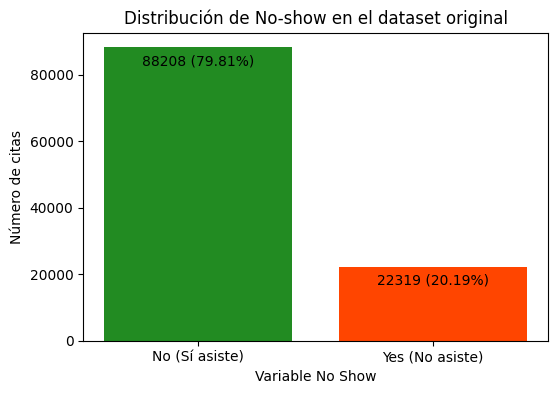

In [12]:
# Distribución de Clases en el dataset original
class_counts = med_app['NoShow'].value_counts()
NUMBER_SHOWS = class_counts[0]
NUMBER_NO_SHOWS = class_counts[1]

plt.figure(figsize = (6, 4))

# Crear el gráfico de barras
plt.bar(x = class_counts.index, 
        height = class_counts.values,   # type: ignore
        tick_label=['No (Sí asiste)', 'Yes (No asiste)'], 
        color = ['forestgreen', 'orangered'])

# Añadir etiquetas a las barras
for i, value in enumerate(class_counts):
        value_percent = value / med_app.shape[0]
        plt.text(x = i,
                y = value-2000,
                s = f'{value} ({value_percent:.2%})',
                ha = 'center',
                va = 'top')

# Configura el título del gráfico
plt.title('Distribución de No-show en el dataset original')
plt.xlabel('Variable No Show')
plt.ylabel('Número de citas')

# Muestra el gráfico
plt.show()

**EL DATASET ESTÁ FUERTEMENTE DESBALANCEADO.**

## 1.2 Análisis 1ª característica: Número de Paciente **'PatientId'**.

In [13]:
NUMBER_PATIENTS = med_app['PatientId'].nunique()
patients_format = med_app['PatientId'].dtype
print(f'Hay \033[1m{NUMBER_PATIENTS} pacientes distintos\033[0m, \
expresados con números enteros {patients_format}.')

min_patient = med_app['PatientId'].min()
max_patient = med_app['PatientId'].max()
print(f'Dicho indicador comprende desde el {min_patient} hasta el {max_patient}.')

Hay 62299 pacientes distintos, expresados con números enteros int64.
Dicho indicador comprende desde el 39217 hasta el 999981631772427.


In [14]:
# Número de citas por cada paciente
app_per_patient = med_app['PatientId'].value_counts()

# Crear una serie que cuente cuántos pacientes tienen X número de citas
app_counts_summary = app_per_patient.value_counts().sort_index()

# Convertir la serie appointment_counts_summary a un DataFrame y restablecer el índice
app_counts_summary_df = pd.DataFrame({'num_citas': app_counts_summary.index,
                                    'num_pacientes': app_counts_summary.values})

# Aplicar una expresión lambda a la columna 'num_citas' para obtener la columna 'group_num_citas'
app_counts_summary_df['group_num_citas'] = app_counts_summary_df['num_citas'].apply(
    lambda x: str(x) if x < 11 else 'Más de 10')

# Verificar el DataFrame con la nueva columna agregada
print(app_counts_summary_df.head(15))

    num_citas  num_pacientes group_num_citas
0           1          37920               1
1           2          13895               2
2           3           5500               3
3           4           2367               4
4           5           1119               5
5           6            553               6
6           7            306               7
7           8            202               8
8           9            104               9
9          10             85              10
10         11             63       Más de 10
11         12             36       Más de 10
12         13             35       Más de 10
13         14             22       Más de 10
14         15             15       Más de 10


In [15]:
app_counts_summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   num_citas        44 non-null     int64 
 1   num_pacientes    44 non-null     int64 
 2   group_num_citas  44 non-null     object
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [16]:
unique_values = app_counts_summary_df['group_num_citas'].unique()
print(unique_values)

['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' 'Más de 10']


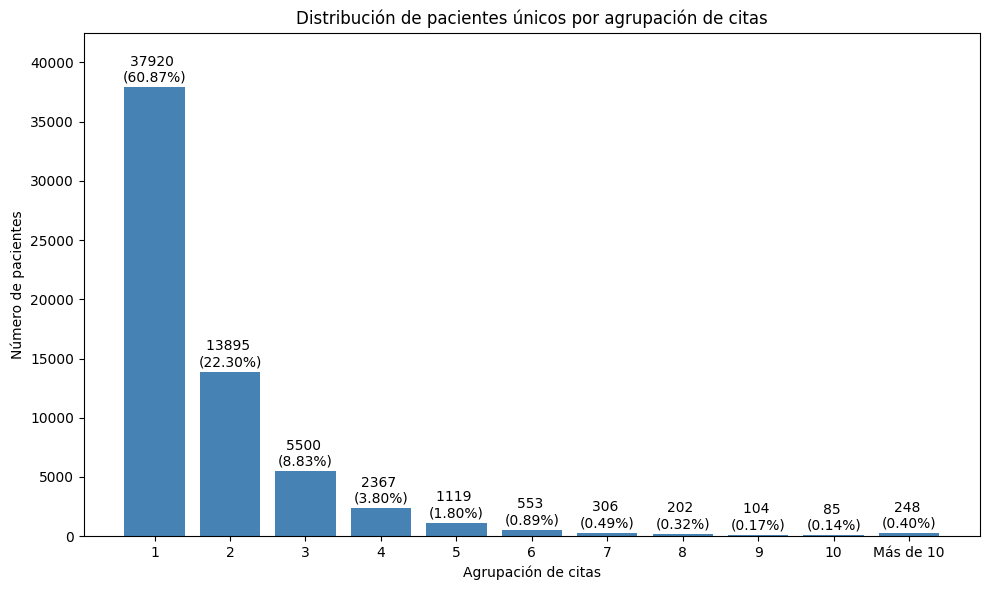

In [17]:
# Convertir 'group_num_citas' a tipo Categorical para conservar el orden
app_counts_summary_df['group_num_citas'] = pd.Categorical(app_counts_summary_df['group_num_citas'], 
                                                        categories=[str(i) for i in range(1, 11)] + ['Más de 10'], 
                                                        ordered=True)

# Agrupar y sumar los valores de 'num_pacientes' por 'group_num_citas'
grouped_df = app_counts_summary_df.groupby('group_num_citas')['num_pacientes'].sum().reset_index()

# Visualización del gráfico
plt.figure(figsize=(10, 6))

plt.bar(grouped_df['group_num_citas'], grouped_df['num_pacientes'], color='steelblue')

# Añadir etiquetas a las barras
for i, value in enumerate(grouped_df['num_pacientes']):
    plt.text(i,
            value+200,
            f'{value} \n({value / NUMBER_PATIENTS:.2%})',
            ha='center',
            va='bottom')

# Configura el título del gráfico
plt.xlabel('Agrupación de citas')
plt.ylabel('Número de pacientes')
plt.title('Distribución de pacientes únicos por agrupación de citas')

# Mostrar el gráfico
plt.ylim(0, 42500)
plt.tight_layout()
plt.show()

## 1.3 Análisis 2ª característica: Número de Cita **'AppointmentID'**.

In [18]:
NUMBER_APPOINTMENTS = med_app['AppointmentID'].nunique()
appointments_format = med_app['AppointmentID'].dtype
print(f'Hay \033[1m{NUMBER_APPOINTMENTS} identificaciones de citas distintas\033[0m,\n \
una por cada muestra del dataset (= {NUMBER_SAMPLES}),\n \
expresadas con números enteros {appointments_format}.\n')

min_app = med_app['AppointmentID'].min()
max_app = med_app['AppointmentID'].max()
print(f'Dicho indicador comprende desde el {min_app} hasta el {max_app}.')

Hay 110527 identificaciones de citas distintas,
 una por cada muestra del dataset (= 110527),
 expresadas con números enteros int64.

Dicho indicador comprende desde el 5030230 hasta el 5790484.


## 1.4 Análisis 3ª característica: Género **'Gender'**.

In [19]:
gender_format = med_app['Gender'].dtype
print(f"Hay \033[1m{med_app['Gender'].nunique()} géneros identificados\033[0m:\n \
\t{med_app['Gender'].unique()}\n \
expresados en {gender_format} string.\n")

NUMBER_FEMALE_APPs = med_app[med_app['Gender'] == 'F'].shape[0]
NUMBER_MALE_APPs = med_app[med_app['Gender'] == 'M'].shape[0]
print("Y distribuidos de la siguiente forma:")
print(f"\tFemale: '{med_app['Gender'].unique()[0]}' = {NUMBER_FEMALE_APPs} citas = \
{NUMBER_FEMALE_APPs / NUMBER_SAMPLES:.2%}.")
print(f"\tMale: '{med_app['Gender'].unique()[1]}' = {NUMBER_MALE_APPs} citas = \
{NUMBER_MALE_APPs / NUMBER_SAMPLES:.2%}.")

Hay 2 géneros identificados:
 	['F' 'M']
 expresados en object string.

Y distribuidos de la siguiente forma:
	Female: 'F' = 71840 citas = 65.00%.
	Male: 'M' = 38687 citas = 35.00%.


In [20]:
# Comprobar que cada Paciente tiene un único género asignado:
grouped_med_app = med_app.groupby('PatientId')['Gender'].unique().explode().reset_index()

if grouped_med_app.shape[0] == NUMBER_PATIENTS:
    print("El listado de valores únicos de 'Gender' asignado a cada\n \
paciente, y 'explotado', tiene el mismo número de filas que\n \
el número total de pacientes, por lo que \033[1mcada paciente tiene\n \
asignado un único género\033[0m.")
else:
    print("Existe algún paciente con más de un género asignado.")

grouped_med_app

El listado de valores únicos de 'Gender' asignado a cada
 paciente, y 'explotado', tiene el mismo número de filas que
 el número total de pacientes, por lo que cada paciente tiene
 asignado un único género.


,PatientId,Gender
0,39217,F
1,43741,M
2,93779,F
3,141724,M
4,537615,F
...,...,...
62294,999931985292928,M
62295,999934989273974,M
62296,999946536742891,M
62297,999968578354866,F


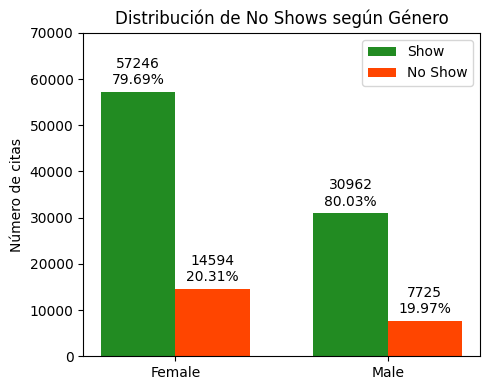

In [21]:
# Análisis distribución de No-shows según 'Gender'
dist = med_app.groupby(['Gender', 'NoShow'])['NoShow'].value_counts().reset_index()
dist_NoShows = dist.pivot(index='Gender', columns='NoShow', values='count')

# Creación de la figura
fig,ax = plt.subplots(figsize = (5, 4))

# Configuración posición y grosor de las barras
x = np.arange(len(dist_NoShows.columns))
width = 0.35
offsets = np.linspace(-width/2, width/2, len(dist_NoShows.columns))

# Creación de todas las Barras
rects_list = []
labels = ['Show', 'No Show']
colors = ['forestgreen', 'orangered']
for i, (no_show, counts) in enumerate(dist_NoShows.items()):
    rects_list.append(ax.bar(x = x + offsets[i],
                            height = counts,
                            width = width,
                            label = labels[i],
                            color = colors[i]))

# Configuración de las etiquetas dentro de las barras
for i in range(2):
    for j in range(2):
        height = rects_list[i][j].get_height()
        total_height = sum(rects_list[k][j].get_height() for k in range(2))
        ax.annotate(f'{height}\n{height/total_height:.2%}',
                    xy = (rects_list[i][j].get_x() + width/2, height),
                    xytext = (0, 25), textcoords = "offset points",
                    ha = 'center', va = 'top')

# Configuración de ejes y título
ax.set_ylabel('Número de citas')
ax.set_title('Distribución de No Shows según Género')
ax.set_xticks(x, ['Female', 'Male'])
ax.set_ylim(0, 70000)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

**ESTA VARIABLE PREDICTORA ESTÁ DESBALANCEADA**

## 1.5 Análisis 4ª característica: Día de programación de cita **'ScheduledDay'**.

In [22]:
ScheduledDay_format = med_app['ScheduledDay'].dtype
print(f"Hay \033[1m{med_app['ScheduledDay'].nunique()} días \
con fecha y hora de programación distintos\033[0m,\n \
expresados en {ScheduledDay_format} (tras modificación inicial).\n")

min_sch_day = med_app['ScheduledDay'].min()
max_sch_day = med_app['ScheduledDay'].max()
print(f'Dicho indicador comprende desde el {min_sch_day}, hasta el {max_sch_day}.')

Hay 103549 días con fecha y hora de programación distintos,
 expresados en datetime64[ns] (tras modificación inicial).

Dicho indicador comprende desde el 2015-11-10 07:13:56, hasta el 2016-06-08 20:07:23.


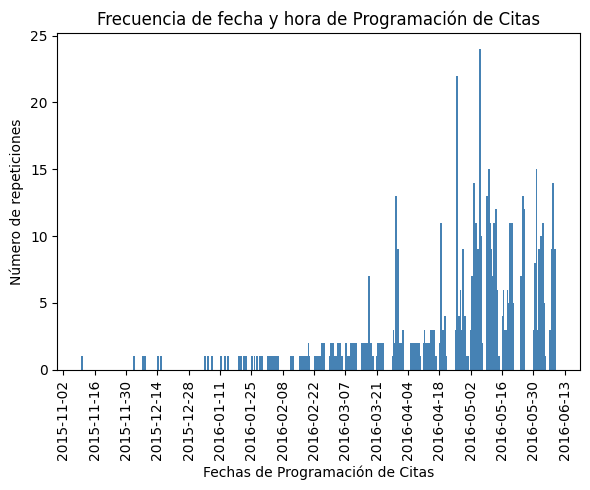

In [23]:
# Serie con la contabilidad de las veces que un mismo Scheduled Day se repite
ScheduledDay_count = med_app['ScheduledDay'].value_counts()

# Crear el gráfico
plt.figure(figsize = (6, 5))

x = ScheduledDay_count.index
y = ScheduledDay_count
plt.bar(x = x, height = y, color = 'steelblue')

plt.xlabel("Fechas de Programación de Citas")
plt.ylabel("Número de repeticiones")
plt.title("Frecuencia de fecha y hora de Programación de Citas")

# Configurar los xticks para que aparezcan cada 14 días.
locator = mdates.WeekdayLocator(byweekday = 0, interval = 2)
plt.gca().xaxis.set_major_locator(locator)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

## 1.6 Análisis 5ª característica: Día de la cita **'AppointmentDay'**.

In [24]:
AppointmentDay_format = med_app['AppointmentDay'].dtype
print(f"Hay \033[1m{med_app['AppointmentDay'].nunique()} días \
con fecha de cita distintos\033[0m,\n \
expresados en {AppointmentDay_format} (tras modificación inicial).\n\
\033[1mNo existe información sobre la hora de la cita.\033[0m\n")

min_app_day = med_app['AppointmentDay'].min().date()
max_app_day = med_app['AppointmentDay'].max().date()
print(f"Dicho indicador comprende desde el {min_app_day}, hasta el {max_app_day}.")

Hay 27 días con fecha de cita distintos,
 expresados en datetime64[ns] (tras modificación inicial).
No existe información sobre la hora de la cita.

Dicho indicador comprende desde el 2016-04-29, hasta el 2016-06-08.


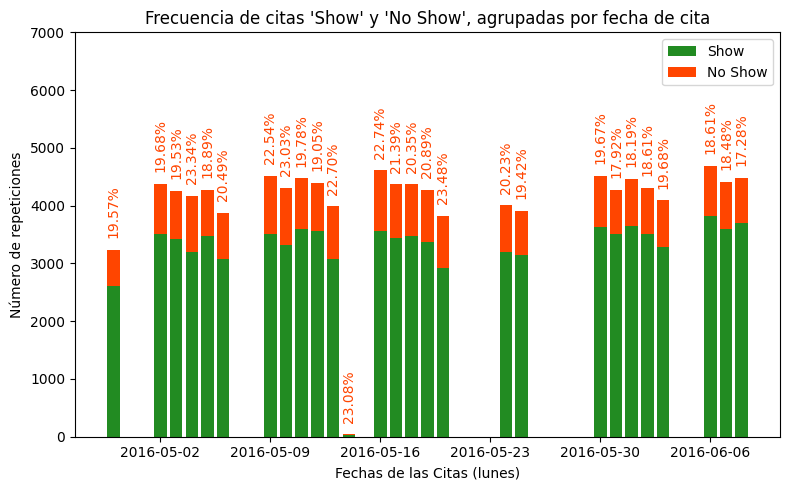

In [25]:
# Serie con la contabilidad de las veces que un mismo Appointment Day se repite
AppointmentDay_count = med_app['AppointmentDay'].value_counts()

# Cálculo del número de citas 'Show' y 'No Show' por Appointment Day
count_shows_byAppDay = med_app[med_app['NoShow'] == False] \
        .groupby(med_app['AppointmentDay']).size()
count_no_shows_byAppDay = med_app[med_app['NoShow'] == True] \
        .groupby(med_app['AppointmentDay']).size()

# Crear el gráfico
plt.figure(figsize = (8, 5))

# Barras de 'Shows'
plt.bar(x = count_shows_byAppDay.index,
        height = count_shows_byAppDay,
        label = 'Show',
        color = 'forestgreen')

# Barras de 'No Shows', apiladas sobre las de Shows
plt.bar(x = count_no_shows_byAppDay.index,
        height = count_no_shows_byAppDay,
        bottom = count_shows_byAppDay[count_no_shows_byAppDay.index],
        label = 'No Show',
        color = 'orangered')

# Etiquetas de las barras
for day in count_shows_byAppDay.index:
        no_shows_percent = count_no_shows_byAppDay[day] / AppointmentDay_count[day]
        plt.text(x = day,
                y = AppointmentDay_count[day]+200,
                s = f'{no_shows_percent:.2%}',
                ha = 'center',
                va = 'bottom',
                rotation = 90,
                color = 'orangered')

# Configuración títulos de gráfico y ejes, y leyenda
plt.xlabel("Fechas de las Citas (lunes)")
plt.ylabel("Número de repeticiones")
plt.title("Frecuencia de citas 'Show' y 'No Show', agrupadas por fecha de cita")
plt.legend()

# Configurar los xticks para que aparezcan cada 7 días, contando desde el 1er lunes.
locator = mdates.WeekdayLocator(byweekday = 0, interval = 1)
plt.gca().xaxis.set_major_locator(locator)

plt.ylim(0, 7000)
plt.tight_layout()
plt.show()

## 1.7 Análisis 6ª característica: Edad **'Age'**.

In [26]:
Age_format = med_app['Age'].dtype
print(f"Hay \033[1m{med_app['Age'].nunique()} edades distintas\033[0m, \
expresadas en números {Age_format}.\n")

min_age = med_app['Age'].min()
max_age = med_app['Age'].max()
print(f'Dicho indicador comprende desde el {min_age}, hasta el {max_age}.')

Hay 104 edades distintas, expresadas en números int64.

Dicho indicador comprende desde el -1, hasta el 115.


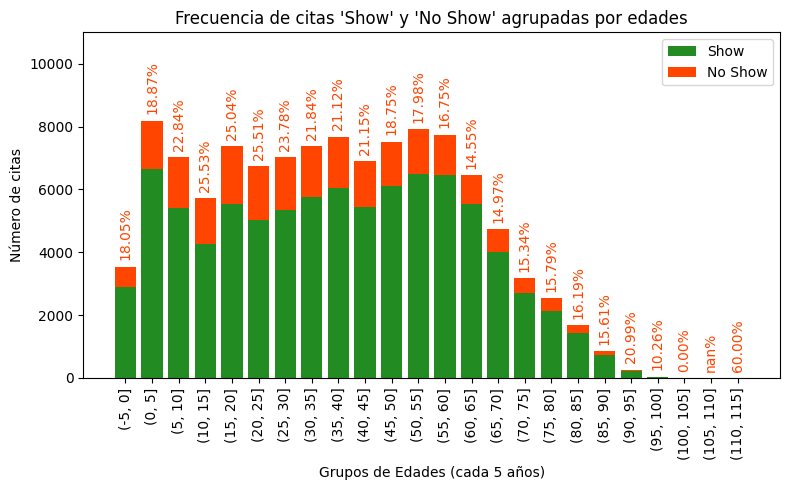

In [27]:
# Distribución de edades en grupos de 5 años
Age_groups = pd.cut(med_app['Age'], bins = range(-5, 120, 5))

# Calcular el número de citas para cada grupo de edades
Age_groups_count = Age_groups.value_counts().sort_index()

# Guardar las posiciones en el eje x de cada una de las barras
Age_xticks = Age_groups_count.index.map(lambda x: x.left)

# Guardar las etiquetas de los grupos de edades
Age_xticks_labels = [f"({x.left}, {x.right}]" for x in Age_groups_count.index]

# Cálculo del número de citas 'Show' y 'No Show' por grupo de edad
count_shows_byAge = med_app[med_app['NoShow'] == False].groupby(Age_groups).size()
count_no_shows_byAge = med_app[med_app['NoShow'] == True].groupby(Age_groups).size()

# Crear el gráfico
plt.figure(figsize=(8, 5))

# Barras de 'Shows'
plt.bar(x = Age_xticks,
        height = count_shows_byAge,
        width = 4,
        label = 'Show',
        color = 'forestgreen')

# Barras de 'No Shows', apiladas sobre las de Shows
plt.bar(x = Age_xticks,
        height = count_no_shows_byAge,
        width = 4,
        bottom = count_shows_byAge[count_no_shows_byAge.index],
        label = 'No Show',
        color = 'orangered')

# Etiquetas de las barras
for group in Age_xticks:
        no_shows_percent = count_no_shows_byAge[group+1] / Age_groups_count[group+1]
        plt.text(x = group,
                y = Age_groups_count[group+1]+200,
                s = f'{no_shows_percent:.2%}',
                ha = 'center',
                va = 'bottom',
                rotation = 90,
                color = 'orangered')

# Configuración títulos de gráfico y ejes, etiquetas del eje x, y leyenda
plt.xlabel("Grupos de Edades (cada 5 años)")
plt.ylabel("Número de citas")
plt.title("Frecuencia de citas 'Show' y 'No Show' agrupadas por edades")
plt.xticks(ticks = Age_xticks,
        labels = Age_xticks_labels,
        rotation = 90)
plt.legend()

plt.ylim(0, 11000)
plt.tight_layout()
plt.show()

**LOS PACIENTES ENTRE 5 Y 30 AÑOS SON LOS QUE MÁS FALTAN A LAS CITAS, ASÍ COMO LOS MAYORES DE 110 AÑOS**

Aunque esto último es un valor outlier:

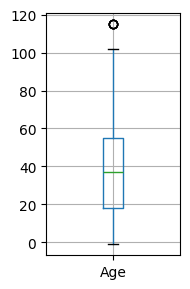

In [28]:
# Gráfico de Caja y Bigotes para la detección de Outliers

plt.figure(figsize = (2, 3))
ax = med_app.boxplot(column = 'Age')

plt.tight_layout()
plt.show()

In [29]:
# Visualizar las edades más bajas y las más altas.
Age_count = med_app['Age'].value_counts().sort_index()

print(Age_count.iloc[0:4], "\n")
print(Age_count.iloc[-4:])

Age
-1       1
 0    3539
 1    2273
 2    1618
Name: count, dtype: int64 

Age
99     1
100    4
102    2
115    5
Name: count, dtype: int64


Existe una cita con un paciente de edad -1. Puede ser un error o la edad de una mujer embarazada.
Existen 5 citas con un paciente de 115 años. Es raro, pero se puede alcanzar dicha edad. Comprobaremos si las 5 citas corresponden al mismo paciente, o pacientes distintos.

In [30]:
# Cita de paciente con edad = -1.
edad = -1
print(f"Existe {med_app.loc[med_app['Age'] == edad]['PatientId'].nunique()} paciente \
con edad negativa = {edad}.")
med_app.loc[med_app['Age'] == -1]

Existe 1 paciente con edad negativa = -1.


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,NoShow
99832,465943158731293,5775010,F,2016-06-06 08:58:13,2016-06-06,-1,ROMÃO,0,0,0,0,0,0,False


*Asumimos que este paciente es una madre que se va a hacer revisión de embarazo.*

*Respecto a las citas de pacientes con edad de 0 años, asumimos que los pacientes son recién nacidos.*

Comprobamos la asunción verificando que no haya ninguno con historial de Hipertensión, Diabetes o Alcoholismo:

In [31]:
filtered_patients = med_app[(med_app.Age <= 0) &
                                ((med_app.Hypertension.astype(int) == 1) |
                                (med_app.Diabetes.astype(int) == 1) |
                                (med_app.Alcoholism.astype(int) == 1)
                                )
                            ]

if filtered_patients.empty:
    print("No existe ningún paciente de 0 años con antecedentes de \
Hipertensión, Diabetes o Alcoholismo.")
else:
    print(med_app[(med_app.Age <= 0) &
            ((med_app.Hypertension.astype(int) == 1) |
            (med_app.Diabetes.astype(int) == 1) |
            (med_app.Alcoholism.astype(int) == 1))])

No existe ningún paciente de 0 años con antecedentes de Hipertensión, Diabetes o Alcoholismo.


**Sin embargo, este análisis da pie a replantear la estrategia usada para verificar la probabilidad de asistencia, pues sería más realista buscar los antecedentes en la madre o padre que lleve el bebé a revisión, y no los del paciente bebé.**

In [32]:
# Citas de pacientes con edad = 115.
edad = 115
print(f"Existen {med_app.loc[med_app['Age'] == edad]['PatientId'].nunique()} pacientes \
con {edad} años.")
med_app.loc[med_app['Age'] == edad]

Existen 2 pacientes con 115 años.


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,NoShow
68127,31963211613981,5562812,F,2016-04-08 14:29:17,2016-05-16,115,ANDORINHAS,0,0,0,0,1,0,True
63912,31963211613981,5700278,F,2016-05-16 09:17:44,2016-05-19,115,ANDORINHAS,0,0,0,0,1,0,True
63915,31963211613981,5700279,F,2016-05-16 09:17:44,2016-05-19,115,ANDORINHAS,0,0,0,0,1,0,True
76284,31963211613981,5744037,F,2016-05-30 09:44:51,2016-05-30,115,ANDORINHAS,0,0,0,0,1,0,False
97666,748234579244724,5717451,F,2016-05-19 07:57:56,2016-06-03,115,SÃO JOSÉ,0,1,0,0,0,1,False


In [33]:
# Citas de pacientes con edad = 102.
edad = 102
print(f"Existen {med_app.loc[med_app['Age'] == edad]['PatientId'].nunique()} pacientes \
con {edad} años.")
med_app.loc[med_app['Age'] == edad]

Existen 2 pacientes con 102 años.


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,NoShow
90372,234283596548,5751563,F,2016-05-31 10:19:49,2016-06-02,102,MARIA ORTIZ,0,0,0,0,0,0,False
58014,976294799775439,5651757,F,2016-05-03 09:14:53,2016-05-03,102,CONQUISTA,0,0,0,0,0,0,False


In [34]:
# Citas de pacientes con edad = 100.
edad = 100
print(f"Existen {med_app.loc[med_app['Age'] == edad]['PatientId'].nunique()} pacientes \
con {edad} años.")
med_app.loc[med_app['Age'] == edad]

Existen 3 pacientes con 100 años.


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,NoShow
108506,393964189799,5721152,F,2016-05-19 15:32:09,2016-06-01,100,MARUÍPE,0,0,0,0,0,0,False
79270,9739429797896,5747809,M,2016-05-30 16:21:56,2016-05-31,100,TABUAZEIRO,0,0,0,0,1,0,False
79272,9739429797896,5747808,M,2016-05-30 16:21:56,2016-05-31,100,TABUAZEIRO,0,0,0,0,1,0,False
92084,55783129426615,5670914,F,2016-05-06 14:55:36,2016-06-03,100,ANTÔNIO HONÓRIO,0,0,0,0,0,1,False


In [35]:
# Comprobar que cada Paciente tiene una única edad registrada:
grouped_med_app = med_app.groupby('PatientId')['Age'].unique().explode().reset_index()
grouped_med_app['Age'] = grouped_med_app['Age'].astype(int)

if grouped_med_app.shape[0] == NUMBER_PATIENTS:
    print("El listado de valores únicos de 'Age' asignado a cada\n \
paciente, y 'explotado', tiene el mismo número de filas que\n \
el número total de pacientes, por lo que \033[1mcada paciente tiene\n \
asignado un único género\033[0m.")
else:
    print(f"Existen {grouped_med_app.shape[0]-NUMBER_PATIENTS} \
pacientes con más de una edad asignada.")
    count_index = 0
    for i in range(grouped_med_app.shape[0]-1):
        if grouped_med_app.loc[i, 'PatientId'] == grouped_med_app.loc[i+1, 'PatientId']:
            if grouped_med_app.loc[i+1, 'Age'] - grouped_med_app.loc[i, 'Age'] > 1:   # type: ignore
                print(f"Las edades del paciente {grouped_med_app.loc[i+1, 'PatientId']} \
están mal indicadas")
                count_index += 1
    if count_index != 0:
        print(f"Existen {count_index} pacientes con las edades incoherentes entre citas.")
    else:
        print(f"Sin embargo, todas las diferencias de edad reveladas son máximo de 1 año, \n \
por lo que podemos asumir que son pacientes que han cumplido años entre una cita y otra.")


Existen 1168 pacientes con más de una edad asignada.
Sin embargo, todas las diferencias de edad reveladas son máximo de 1 año, 
 por lo que podemos asumir que son pacientes que han cumplido años entre una cita y otra.


## 1.8 Análisis 7ª característica: Barrio **'Neighbourhood'**.

In [36]:
Neighbourhood_format = med_app['Neighbourhood'].dtype
print(f"Hay \033[1m{med_app['Neighbourhood'].nunique()} \
valores de 'Neighbourhood' distintos\033[0m:\n \
{med_app['Neighbourhood'].unique()}, \
expresados por {Neighbourhood_format} string.")

Hay 81 valores de 'Neighbourhood' distintos:
 ['PRAIA DO SUÁ' 'MARIA ORTIZ' 'CENTRO' 'FORTE SÃO JOÃO' 'PARQUE MOSCOSO'
 'SANTO ANTÔNIO' 'INHANGUETÁ' 'JARDIM DA PENHA' 'ITARARÉ' 'GRANDE VITÓRIA'
 'MARUÍPE' 'CARATOÍRA' 'NOVA PALESTINA' 'ILHA DAS CAIEIRAS' 'DA PENHA'
 'ROMÃO' 'JESUS DE NAZARETH' 'SANTA CLARA' 'ARIOVALDO FAVALESSA'
 'SEGURANÇA DO LAR' 'CONSOLAÇÃO' 'SÃO CRISTÓVÃO' 'SANTOS REIS'
 'JARDIM CAMBURI' 'DO QUADRO' 'BENTO FERREIRA' 'PIEDADE' 'SANTO ANDRÉ'
 'TABUAZEIRO' 'SÃO JOSÉ' 'FONTE GRANDE' 'SÃO PEDRO' 'SANTA MARTHA'
 'CRUZAMENTO' 'JOANA D´ARC' 'SANTA CECÍLIA' 'ILHA DO PRÍNCIPE'
 'JUCUTUQUARA' 'SANTOS DUMONT' 'REDENÇÃO' 'BELA VISTA' 'SANTA TEREZA'
 'SÃO BENEDITO' 'RESISTÊNCIA' 'GURIGICA' 'DO MOSCOSO' 'BONFIM' 'DO CABRAL'
 'MATA DA PRAIA' 'ANDORINHAS' 'UNIVERSITÁRIO' 'ILHA DE SANTA MARIA'
 'DE LOURDES' 'SOLON BORGES' 'ANTÔNIO HONÓRIO' 'JABOUR' 'COMDUSA'
 'MONTE BELO' 'PRAIA DO CANTO' 'ENSEADA DO SUÁ' 'SANTA LÚCIA' 'VILA RUBIM'
 'GOIABEIRAS' 'BARRO VERMELHO' 'ESTRELINHA' 'REPÚBLI

(81,)


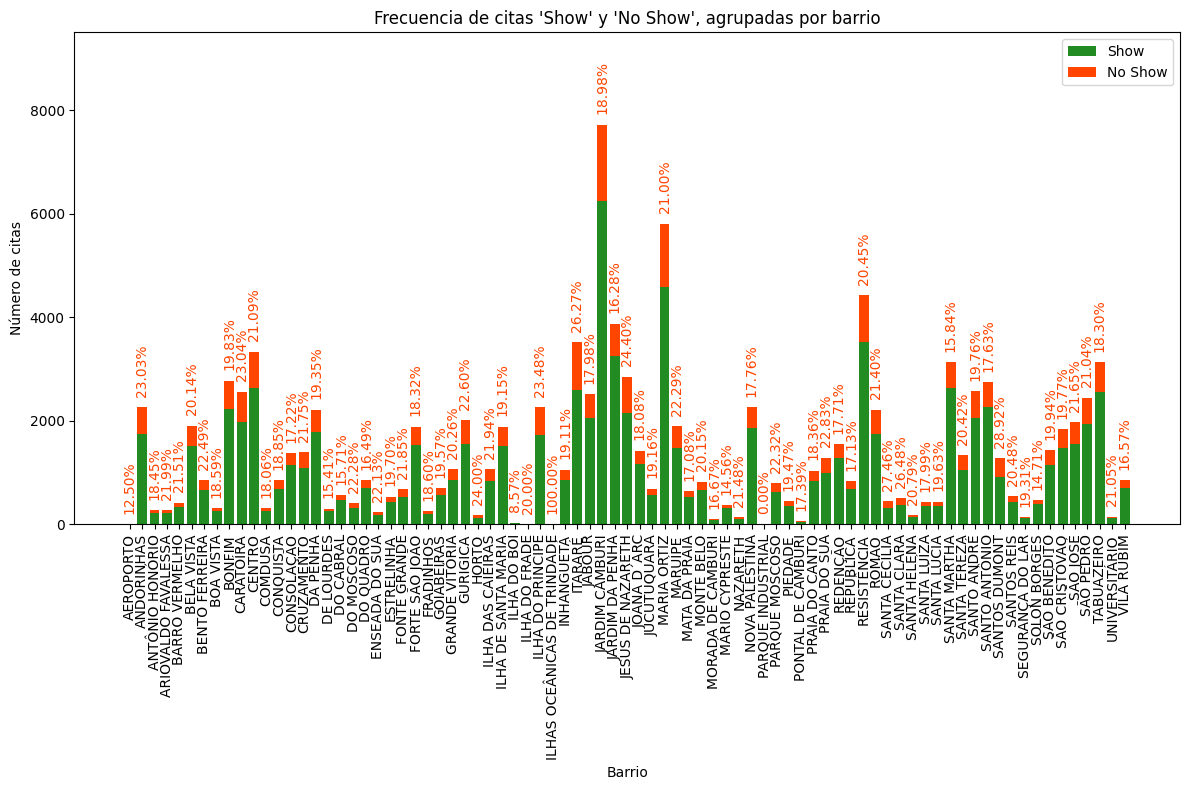

In [37]:
# Serie con la contabilidad de las Citas realizadas en cada barrio:
Neigh_count = med_app['Neighbourhood'].value_counts()

# Cálculo del número de citas 'Show' y 'No Show' por barrio:
count_shows_byNeigh = med_app[med_app['NoShow'] == False] \
        .groupby(med_app['Neighbourhood']).size()
count_no_shows_byNeigh = med_app[med_app['NoShow'] == True] \
        .groupby(med_app['Neighbourhood']).size()

# Reindexar para asegurar que ambos DataFrames tengan los mismos índices
combined_index = count_shows_byNeigh.index.union(count_no_shows_byNeigh.index)
count_shows_byNeigh = count_shows_byNeigh.reindex(combined_index, fill_value=0)
count_no_shows_byNeigh = count_no_shows_byNeigh.reindex(combined_index, fill_value=0)

# Crear el gráfico
plt.figure(figsize = (12, 8))

# Barras de 'Shows'
ax = plt.bar(x = count_shows_byNeigh.index,
        height = count_shows_byNeigh,
        label = 'Show',
        color = 'forestgreen')
print(count_shows_byNeigh.index.shape)

# Barras de 'No Shows', apiladas sobre las de Shows
plt.bar(x = count_no_shows_byNeigh.index,
        height = count_no_shows_byNeigh,
        bottom = count_shows_byNeigh[count_no_shows_byNeigh.index],
        label = 'No Show',
        color = 'orangered')

# Etiquetas de las barras
for neigh in count_shows_byNeigh.index:
        no_shows_percent = count_no_shows_byNeigh[neigh] / Neigh_count[neigh]
        plt.text(x = neigh,
                y = Neigh_count[neigh]+200,
                s = f'{no_shows_percent:.2%}',
                ha = 'center',
                va = 'bottom',
                rotation = 90,
                color = 'orangered')

# Configuración títulos de gráfico y ejes, y leyenda
plt.xlabel("Barrio")
plt.xticks(rotation = 90)
plt.ylabel("Número de citas")
plt.title("Frecuencia de citas 'Show' y 'No Show', agrupadas por barrio")
plt.legend()

plt.ylim(0, 9500)
plt.tight_layout()
plt.show()

**ESTA VARIABLE PREDICTORA ESTÁ MUY DESBALANCEADA**

## 1.9 Análisis 8ª característica: Bolsa Familia **'Scholarship'**.

In [38]:
Scholarship_format = med_app['Scholarship'].dtype
print(f"Hay \033[1m{med_app['Scholarship'].nunique()} \
valores de 'Scholarship' distintos\033[0m:\n \
{med_app['Scholarship'].unique()}, \
expresados por 2 números enteros {Scholarship_format}.\n")

NUMBER_NO_SCHOLARSHIP_APPs = med_app[med_app['Scholarship'] == 0].shape[0]
NUMBER_SCHOLARSHIP_APPs = med_app[med_app['Scholarship'] == 1].shape[0]
print("Y distribuidos de la siguiente forma:")
print(f"\tSin Scholarship: '{med_app['Scholarship'].unique()[0]}' = {NUMBER_NO_SCHOLARSHIP_APPs} citas = \
{NUMBER_NO_SCHOLARSHIP_APPs / NUMBER_SAMPLES:.2%}.")
print(f"\tCon scholarship: '{med_app['Scholarship'].unique()[1]}' = {NUMBER_SCHOLARSHIP_APPs} citas = \
{NUMBER_SCHOLARSHIP_APPs / NUMBER_SAMPLES:.2%}.")

Hay 2 valores de 'Scholarship' distintos:
 [0 1], expresados por 2 números enteros int64.

Y distribuidos de la siguiente forma:
	Sin Scholarship: '0' = 99666 citas = 90.17%.
	Con scholarship: '1' = 10861 citas = 9.83%.


In [39]:
# Comprobar que cada Paciente tiene un único valor de Bolsa Familia ('Scholarship') asignado:
grouped_med_app = med_app.groupby('PatientId')['Scholarship'].unique().explode().reset_index()

if grouped_med_app.shape[0] == NUMBER_PATIENTS:
    print("El listado de valores únicos de 'Scholarship' asignado a cada\n \
paciente, y 'explotado', tiene el mismo número de filas que\n \
el número total de pacientes, por lo que \033[1mcada paciente tiene\n \
asignado un único valor de Bolsa Familia\033[0m.")
else:
    print("Existe algún paciente con más de un valor de Bolsa Familia.")

grouped_med_app

El listado de valores únicos de 'Scholarship' asignado a cada
 paciente, y 'explotado', tiene el mismo número de filas que
 el número total de pacientes, por lo que cada paciente tiene
 asignado un único valor de Bolsa Familia.


,PatientId,Scholarship
0,39217,0
1,43741,0
2,93779,0
3,141724,0
4,537615,0
...,...,...
62294,999931985292928,0
62295,999934989273974,0
62296,999946536742891,1
62297,999968578354866,0


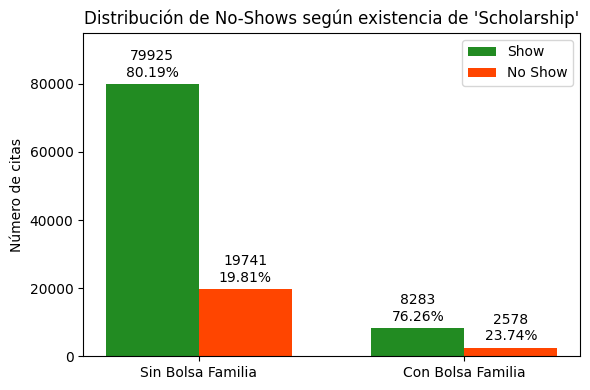

In [40]:
# Análisis distribución de No-shows según 'Scholarship'
dist = med_app.groupby(['Scholarship', 'NoShow'])['NoShow'].value_counts().reset_index()
dist_NoShows = dist.pivot(index='Scholarship', columns='NoShow', values='count')

# Creación de la figura
fig,ax = plt.subplots(figsize = (6, 4))

# Configuración posición y grosor de las barras
x = np.arange(len(dist_NoShows.columns))
width = 0.35
offsets = np.linspace(-width/2, width/2, len(dist_NoShows.columns))

# Creación de todas las Barras
rects_list = []
labels = ['Show', 'No Show']
colors =['forestgreen', 'orangered']
for i, (no_show, counts) in enumerate(dist_NoShows.items()):
    rects_list.append(ax.bar(x = x + offsets[i],
                            height = counts,
                            width = width,
                            label = labels[i],
                            color = colors[i]))

# Configuración de las etiquetas dentro de las barras
for i in range(2):
    for j in range(2):
        height = rects_list[i][j].get_height()
        total_height = sum(rects_list[k][j].get_height() for k in range(2))
        ax.annotate(f'{height}\n{height/total_height:.2%}',
                    xy = (rects_list[i][j].get_x() + width/2, height),
                    xytext = (0, 25), textcoords = "offset points",
                    ha = 'center', va = 'top')

# Configuración de ejes y título
ax.set_ylabel('Número de citas')
ax.set_title("Distribución de No-Shows según existencia de 'Scholarship'")
ax.set_xticks(x, ['Sin Bolsa Familia', 'Con Bolsa Familia'])
ax.legend(loc='upper right')
ax.set_ylim(0, 95000)

plt.tight_layout()
plt.show()

**ESTA VARIABLE PREDICTORA ESTÁ FUERTEMENTE DESBALANCEADA**

## 1.10 Análisis 9ª característica: Hipertensión **'Hypertension'**.

In [41]:
Hypertension_format = med_app['Hypertension'].dtype
print(f"Hay \033[1m{med_app['Hypertension'].nunique()} \
valores de Hipertensión distintos\033[0m:\n \
{med_app['Hypertension'].unique()}, \
expresados por 2 números enteros {Hypertension_format}.\n")

NUMBER_NO_HYPERTENSION_APPs = med_app[med_app['Hypertension'] == 0].shape[0]
NUMBER_HYPERTENSION_APPs = med_app[med_app['Hypertension'] == 1].shape[0]
print("Y distribuidos de la siguiente forma:")
print(f"\tSin Hipertensión: '{med_app['Hypertension'].unique()[0]}' = {NUMBER_NO_HYPERTENSION_APPs} citas = \
{NUMBER_NO_HYPERTENSION_APPs / NUMBER_SAMPLES:.2%}.")
print(f"\tCon Hipertensión: '{med_app['Hypertension'].unique()[1]}' = {NUMBER_HYPERTENSION_APPs} citas = \
{NUMBER_HYPERTENSION_APPs / NUMBER_SAMPLES:.2%}.")

Hay 2 valores de Hipertensión distintos:
 [0 1], expresados por 2 números enteros int64.

Y distribuidos de la siguiente forma:
	Sin Hipertensión: '0' = 88726 citas = 80.28%.
	Con Hipertensión: '1' = 21801 citas = 19.72%.


In [42]:
# Comprobar que cada Paciente tiene un único valor de Hipertensión asignado:
grouped_med_app = med_app.groupby('PatientId')['Hypertension'].unique().explode().reset_index()

if grouped_med_app.shape[0] == NUMBER_PATIENTS:
    print("El listado de valores únicos de Hipertensión asignado a cada\n \
paciente, y 'explotado', tiene el mismo número de filas que\n \
el número total de pacientes, por lo que \033[1mcada paciente tiene\n \
asignado un único valor de Hipertensión\033[0m.")
else:
    print("Existe algún paciente con más de un valor de Hipertensión asignado.")

grouped_med_app

El listado de valores únicos de Hipertensión asignado a cada
 paciente, y 'explotado', tiene el mismo número de filas que
 el número total de pacientes, por lo que cada paciente tiene
 asignado un único valor de Hipertensión.


,PatientId,Hypertension
0,39217,0
1,43741,0
2,93779,0
3,141724,0
4,537615,0
...,...,...
62294,999931985292928,0
62295,999934989273974,0
62296,999946536742891,1
62297,999968578354866,0


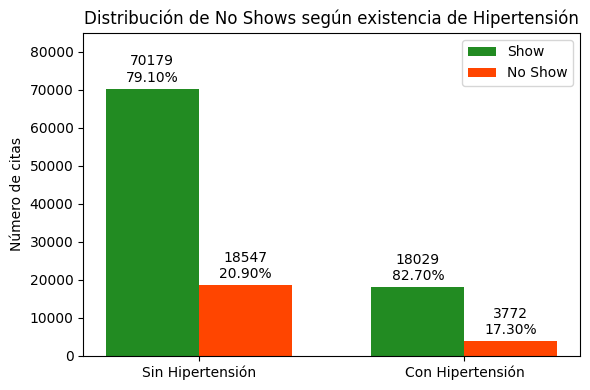

In [43]:
# Análisis distribución de No-shows según 'Hipertension'
dist = med_app.groupby(['Hypertension', 'NoShow'])['NoShow'].value_counts().reset_index()
dist_NoShows = dist.pivot(index='Hypertension', columns='NoShow', values='count')

# Creación de la figura
fig,ax = plt.subplots(figsize = (6, 4))

# Configuración posición y grosor de las barras
x = np.arange(len(dist_NoShows.columns))
width = 0.35
offsets = np.linspace(-width/2, width/2, len(dist_NoShows.columns))

# Creación de todas las Barras
rects_list = []
labels = ['Show', 'No Show']
colors =['forestgreen', 'orangered']
for i, (no_show, counts) in enumerate(dist_NoShows.items()):
    rects_list.append(ax.bar(x = x + offsets[i],
                            height = counts,
                            width = width,
                            label = labels[i],
                            color = colors[i]))

# Configuración de las etiquetas dentro de las barras
for i in range(2):
    for j in range(2):
        height = rects_list[i][j].get_height()
        total_height = sum(rects_list[k][j].get_height() for k in range(2))
        ax.annotate(f'{height}\n{height/total_height:.2%}',
                    xy = (rects_list[i][j].get_x() + width/2, height),
                    xytext = (0, 25), textcoords = "offset points",
                    ha = 'center', va = 'top')

# Configuración de ejes y título
ax.set_ylabel('Número de citas')
ax.set_title("Distribución de No Shows según existencia de Hipertensión")
ax.set_xticks(x, ['Sin Hipertensión', 'Con Hipertensión'])
ax.legend(loc='upper right')
ax.set_ylim(0, 85000)

plt.tight_layout()
plt.show()

**ESTA VARIABLE PREDICTORA ESTÁ FUERTEMENTE DESBALANCEADA**

## 1.11 Análisis 10ª característica: Diabetes **'Diabetes'**.

In [44]:
Diabetes_format = med_app['Diabetes'].dtype
print(f"Hay \033[1m{med_app['Diabetes'].nunique()} \
valores de Diabetes distintos\033[0m:\n \
{med_app['Diabetes'].unique()}, \
expresados por 2 números enteros {Diabetes_format}.\n")

NUMBER_NO_DIABETES_APPs = med_app[med_app['Diabetes'] == 0].shape[0]
NUMBER_DIABETES_APPs = med_app[med_app['Diabetes'] == 1].shape[0]
print("Y distribuidos de la siguiente forma:")
print(f"\tSin Diabetes: '{med_app['Diabetes'].unique()[0]}' = {NUMBER_NO_DIABETES_APPs} citas = \
{NUMBER_NO_DIABETES_APPs / NUMBER_SAMPLES:.2%}.")
print(f"\tCon Diabetes: '{med_app['Diabetes'].unique()[1]}' = {NUMBER_DIABETES_APPs} citas = \
{NUMBER_DIABETES_APPs / NUMBER_SAMPLES:.2%}.")

Hay 2 valores de Diabetes distintos:
 [0 1], expresados por 2 números enteros int64.

Y distribuidos de la siguiente forma:
	Sin Diabetes: '0' = 102584 citas = 92.81%.
	Con Diabetes: '1' = 7943 citas = 7.19%.


In [45]:
# Comprobar que cada Paciente tiene un único valor de Diabetes asignado:
grouped_med_app = med_app.groupby('PatientId')['Diabetes'].unique().explode().reset_index()

if grouped_med_app.shape[0] == NUMBER_PATIENTS:
    print("El listado de valores únicos de Diabetes asignado a cada\n \
paciente, y 'explotado', tiene el mismo número de filas que\n \
el número total de pacientes, por lo que \033[1mcada paciente tiene\n \
asignado un único valor de Diabetes\033[0m.")
else:
    print("Existe algún paciente con más de un valor de Diabetes asignado.")

grouped_med_app

El listado de valores únicos de Diabetes asignado a cada
 paciente, y 'explotado', tiene el mismo número de filas que
 el número total de pacientes, por lo que cada paciente tiene
 asignado un único valor de Diabetes.


,PatientId,Diabetes
0,39217,0
1,43741,1
2,93779,0
3,141724,0
4,537615,0
...,...,...
62294,999931985292928,0
62295,999934989273974,0
62296,999946536742891,0
62297,999968578354866,0


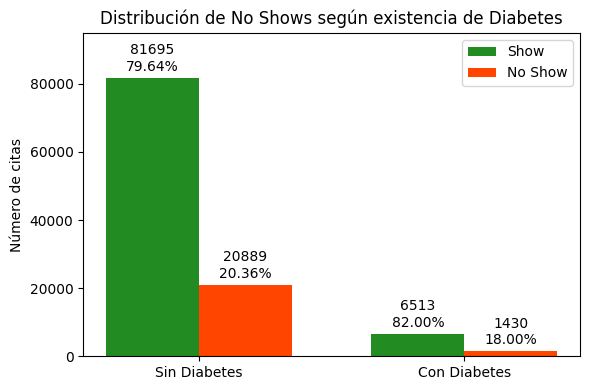

In [46]:
# Análisis distribución de No-shows según 'Diabetes'
dist = med_app.groupby(['Diabetes', 'NoShow'])['NoShow'].value_counts().reset_index()
dist_NoShows = dist.pivot(index='Diabetes', columns='NoShow', values='count')

# Creación de la figura
fig,ax = plt.subplots(figsize = (6, 4))

# Configuración posición y grosor de las barras
x = np.arange(len(dist_NoShows.columns))
width = 0.35
offsets = np.linspace(-width/2, width/2, len(dist_NoShows.columns))

# Creación de todas las Barras
rects_list = []
labels = ['Show', 'No Show']
colors =['forestgreen', 'orangered']
for i, (no_show, counts) in enumerate(dist_NoShows.items()):
    rects_list.append(ax.bar(x = x + offsets[i],
                            height = counts,
                            width = width,
                            label = labels[i],
                            color = colors[i]))

# Configuración de las etiquetas dentro de las barras
for i in range(2):
    for j in range(2):
        height = rects_list[i][j].get_height()
        total_height = sum(rects_list[k][j].get_height() for k in range(2))
        ax.annotate(f'{height}\n{height/total_height:.2%}',
                    xy = (rects_list[i][j].get_x() + width/2, height),
                    xytext = (0, 25), textcoords = "offset points",
                    ha = 'center', va = 'top')

# Configuración de ejes y título
ax.set_ylabel('Número de citas')
ax.set_title("Distribución de No Shows según existencia de Diabetes")
ax.set_xticks(x, ['Sin Diabetes', 'Con Diabetes'])
ax.legend(loc='upper right')
ax.set_ylim(0, 95000)

plt.tight_layout()
plt.show()

**ESTA VARIABLE PREDICTORA ESTÁ FUERTEMENTE DESBALANCEADA**

## 1.12 Análisis 11ª característica: Alcoholismo **'Alcoholism'**.

In [47]:
Diabetes_format = med_app['Alcoholism'].dtype
print(f"Hay \033[1m{med_app['Alcoholism'].nunique()} \
valores de Alcoholismo distintos\033[0m:\n \
{med_app['Alcoholism'].unique()}, \
expresados por 2 números enteros {Diabetes_format}.\n")

NUMBER_NO_ALCOHOLISM_APPs = med_app[med_app['Alcoholism'] == 0].shape[0]
NUMBER_ALCOHOLISM_APPs = med_app[med_app['Alcoholism'] == 1].shape[0]
print("Y distribuidos de la siguiente forma:")
print(f"\tSin Alcoholismo: '{med_app['Alcoholism'].unique()[0]}' = {NUMBER_NO_ALCOHOLISM_APPs} citas = \
{NUMBER_NO_ALCOHOLISM_APPs / NUMBER_SAMPLES:.2%}.")
print(f"\tCon Alcoholismo: '{med_app['Alcoholism'].unique()[1]}' = {NUMBER_ALCOHOLISM_APPs} citas = \
{NUMBER_ALCOHOLISM_APPs / NUMBER_SAMPLES:.2%}.")

Hay 2 valores de Alcoholismo distintos:
 [0 1], expresados por 2 números enteros int64.

Y distribuidos de la siguiente forma:
	Sin Alcoholismo: '0' = 107167 citas = 96.96%.
	Con Alcoholismo: '1' = 3360 citas = 3.04%.


In [48]:
# Comprobar que cada Paciente tiene un único valor de Alcoholismo asignado:
grouped_med_app = med_app.groupby('PatientId')['Alcoholism'].unique().explode().reset_index()

if grouped_med_app.shape[0] == NUMBER_PATIENTS:
    print("El listado de valores únicos de Alcoholismo asignado a cada\n \
paciente, y 'explotado', tiene el mismo número de filas que\n \
el número total de pacientes, por lo que \033[1mcada paciente tiene\n \
asignado un único valor de Alcoholismo\033[0m.")
else:
    print("Existe algún paciente con más de un valor de Alcoholismo asignado.")

grouped_med_app

El listado de valores únicos de Alcoholismo asignado a cada
 paciente, y 'explotado', tiene el mismo número de filas que
 el número total de pacientes, por lo que cada paciente tiene
 asignado un único valor de Alcoholismo.


,PatientId,Alcoholism
0,39217,0
1,43741,0
2,93779,0
3,141724,0
4,537615,0
...,...,...
62294,999931985292928,0
62295,999934989273974,0
62296,999946536742891,0
62297,999968578354866,0


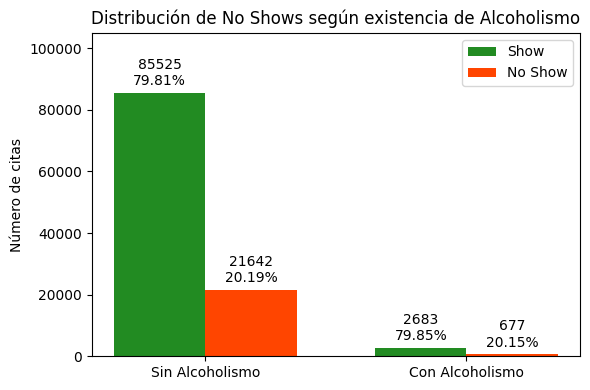

In [49]:
# Análisis distribución de No-shows según 'Alcoholism'
dist = med_app.groupby(['Alcoholism', 'NoShow'])['NoShow'].value_counts().reset_index()
dist_NoShows = dist.pivot(index='Alcoholism', columns='NoShow', values='count')

# Creación de la figura
fig,ax = plt.subplots(figsize = (6, 4))

# Configuración posición y grosor de las barras
x = np.arange(len(dist_NoShows.columns))
width = 0.35
offsets = np.linspace(-width/2, width/2, len(dist_NoShows.columns))

# Creación de todas las Barras
rects_list = []
labels = ['Show', 'No Show']
colors =['forestgreen', 'orangered']
for i, (no_show, counts) in enumerate(dist_NoShows.items()):
    rects_list.append(ax.bar(x = x + offsets[i],
                            height = counts,
                            width = width,
                            label = labels[i],
                            color = colors[i]))

# Configuración de las etiquetas dentro de las barras
for i in range(2):
    for j in range(2):
        height = rects_list[i][j].get_height()
        total_height = sum(rects_list[k][j].get_height() for k in range(2))
        ax.annotate(f'{height}\n{height/total_height:.2%}',
                    xy = (rects_list[i][j].get_x() + width/2, height),
                    xytext = (0, 25), textcoords = "offset points",
                    ha = 'center', va = 'top')

# Configuración de ejes y título
ax.set_ylabel('Número de citas')
ax.set_title("Distribución de No Shows según existencia de Alcoholismo")
ax.set_xticks(x, ['Sin Alcoholismo', 'Con Alcoholismo'])
ax.legend(loc='upper right')
ax.set_ylim(0, 105000)

plt.tight_layout()
plt.show()

**ESTA VARIABLE PREDICTORA ESTÁ FUERTEMENTE DESBALANCEADA**

## 1.13 Análisis 12ª característica: Discapacidades **'Handicap'**.

In [50]:
Diabetes_format = med_app['Handicap'].dtype
print(f"Hay \033[1m{med_app['Handicap'].nunique()} \
valores de Discapacidades distintos\033[0m:\n \
{med_app['Handicap'].unique()}, \
expresados por 5 números enteros {Diabetes_format}.\n")

NUMBER_NO_HANDICAP_APPs = med_app[med_app['Handicap'] == 0].shape[0]
NUMBER_1_HANDICAP_APPs = med_app[med_app['Handicap'] == 1].shape[0]
NUMBER_2_HANDICAP_APPs = med_app[med_app['Handicap'] == 2].shape[0]
NUMBER_3_HANDICAP_APPs = med_app[med_app['Handicap'] == 3].shape[0]
NUMBER_4_HANDICAP_APPs = med_app[med_app['Handicap'] == 4].shape[0]
print("Y distribuidos de la siguiente forma:")
print(f"\tSin Discapacidades: '{med_app['Handicap'].unique()[0]}' = {NUMBER_NO_HANDICAP_APPs} citas = \
{NUMBER_NO_HANDICAP_APPs / NUMBER_SAMPLES:.4%}.")
print(f"\tCon Discapacidad de Grado 1: '{med_app['Handicap'].unique()[1]}' = {NUMBER_1_HANDICAP_APPs} citas = \
{NUMBER_1_HANDICAP_APPs / NUMBER_SAMPLES:.4%}.")
print(f"\tCon Discapacidad de Grado 2: '{med_app['Handicap'].unique()[2]}' = {NUMBER_2_HANDICAP_APPs} citas = \
{NUMBER_2_HANDICAP_APPs / NUMBER_SAMPLES:.4%}.")
print(f"\tCon Discapacidad de Grado 3: '{med_app['Handicap'].unique()[3]}' = {NUMBER_3_HANDICAP_APPs} citas = \
{NUMBER_3_HANDICAP_APPs / NUMBER_SAMPLES:.4%}.")
print(f"\tCon Discapacidad de Grado 4: '{med_app['Handicap'].unique()[4]}' = {NUMBER_4_HANDICAP_APPs} citas = \
{NUMBER_4_HANDICAP_APPs / NUMBER_SAMPLES:.4%}.")

Hay 5 valores de Discapacidades distintos:
 [0 1 2 3 4], expresados por 5 números enteros int64.

Y distribuidos de la siguiente forma:
	Sin Discapacidades: '0' = 108286 citas = 97.9724%.
	Con Discapacidad de Grado 1: '1' = 2042 citas = 1.8475%.
	Con Discapacidad de Grado 2: '2' = 183 citas = 0.1656%.
	Con Discapacidad de Grado 3: '3' = 13 citas = 0.0118%.
	Con Discapacidad de Grado 4: '4' = 3 citas = 0.0027%.


In [51]:
# Comprobar que cada Paciente tiene un único valor de Handicap asignado:
grouped_med_app = med_app.groupby('PatientId')['Handicap'].unique().explode().reset_index()

if grouped_med_app.shape[0] == NUMBER_PATIENTS:
    print("El listado de valores únicos de Discapacidad asignado a cada\n \
paciente, y 'explotado', tiene el mismo número de filas que\n \
el número total de pacientes, por lo que \033[1mcada paciente tiene\n \
asignado un único valor de Discapacidad\033[0m.")
else:
    print("Existe algún paciente con más de un valor de Discapacidad asignado.")

grouped_med_app

El listado de valores únicos de Discapacidad asignado a cada
 paciente, y 'explotado', tiene el mismo número de filas que
 el número total de pacientes, por lo que cada paciente tiene
 asignado un único valor de Discapacidad.


,PatientId,Handicap
0,39217,0
1,43741,0
2,93779,0
3,141724,0
4,537615,0
...,...,...
62294,999931985292928,0
62295,999934989273974,0
62296,999946536742891,0
62297,999968578354866,0


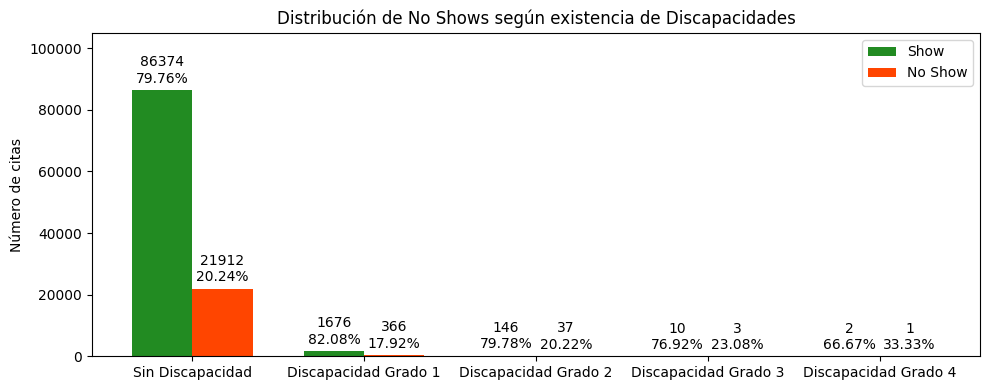

In [52]:
# Análisis distribución de No-shows según 'Handicap'
dist = med_app.groupby(['Handicap', 'NoShow'])['NoShow'].value_counts().reset_index()
dist_NoShows = dist.pivot(index='Handicap', columns='NoShow', values='count')

# Creación de la figura
fig,ax = plt.subplots(figsize = (10, 4))

# Configuración posición y grosor de las barras
x = np.arange(dist_NoShows.shape[0])
width = 0.35
offsets = np.linspace(-width/2, width/2, len(dist_NoShows.columns))

# Creación de todas las Barras
rects_list = []
labels = ['Show', 'No Show']
colors =['forestgreen', 'orangered']
for i, (no_show, counts) in enumerate(dist_NoShows.items()):
    rects_list.append(ax.bar(x = x + offsets[i],
                            height = counts,
                            width = width,
                            label = labels[i],
                            color = colors[i]))

# Configuración de las etiquetas dentro de las barras
for i in range(2):
    for j in range(5):
        height = rects_list[i][j].get_height()
        total_height = sum(rects_list[k][j].get_height() for k in range(2))
        ax.annotate(f'{height}\n{height/total_height:.2%}',
                    xy = (rects_list[i][j].get_x() + width/2, height),
                    xytext = (0, 25), textcoords = "offset points",
                    ha = 'center', va = 'top')

# Configuración de ejes y título
ax.set_ylabel('Número de citas')
ax.set_title("Distribución de No Shows según existencia de Discapacidades")
ax.set_xticks(x, ['Sin Discapacidad',
                    'Discapacidad Grado 1',
                    'Discapacidad Grado 2',
                    'Discapacidad Grado 3',
                    'Discapacidad Grado 4'])
ax.legend(loc='upper right')
ax.set_ylim(0, 105000)

plt.tight_layout()
plt.show()

**ESTA VARIABLE PREDICTORA ESTÁ FUERTEMENTE DESBALANCEADA**

**ES POR ESO QUE LOS DIFERENTES GRADOS DE DISCAPACIDAD SE PUEDEN CONSIDERAR TODOS OUTLIERS:**

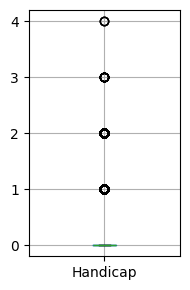

In [53]:
# Gráfico de Caja y Bigotes para la detección de Outliers en la variable 'Handicap'

plt.figure(figsize = (2, 3))
ax = med_app.boxplot(column = 'Handicap')

plt.tight_layout()
plt.show()

In [54]:
# Citas de pacientes con Discapacidad de Grado 4.
Handicap = 4
NUMBER_HANDICAP_4_PATIENTS = med_app.loc[med_app['Handicap'] == Handicap]['PatientId'].nunique()
print(f"Existen {NUMBER_HANDICAP_4_PATIENTS} pacientes con Discapacidad de Grado {Handicap} = \
{NUMBER_HANDICAP_4_PATIENTS / NUMBER_PATIENTS:.4%} del total de Pacientes.")
med_app.loc[med_app['Handicap'] == Handicap]

Existen 3 pacientes con Discapacidad de Grado 4 = 0.0048% del total de Pacientes.


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,NoShow
91820,9251878146849,5789549,M,2016-06-08 15:14:00,2016-06-08,15,DA PENHA,0,0,0,0,4,0,False
98538,497246337172194,5760621,M,2016-06-01 15:11:25,2016-06-03,19,SÃO PEDRO,0,0,0,0,4,0,False
104268,758189466958349,5697136,F,2016-05-13 15:01:17,2016-06-02,9,ITARARÉ,0,0,0,0,4,1,True


In [55]:
# Citas de pacientes con Discapacidad de Grado 3.
Handicap = 3
NUMBER_HANDICAP_3_PATIENTS = med_app.loc[med_app['Handicap'] == Handicap]['PatientId'].nunique()
print(f"Existen {NUMBER_HANDICAP_3_PATIENTS} pacientes con Discapacidad de Grado {Handicap} = \
{NUMBER_HANDICAP_3_PATIENTS / NUMBER_PATIENTS:.4%} del total de Pacientes.")
med_app.loc[med_app['Handicap'] == Handicap]

Existen 6 pacientes con Discapacidad de Grado 3 = 0.0096% del total de Pacientes.


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,NoShow
2214,2754718219582,5640760,M,2016-04-29 11:22:20,2016-04-29,55,DO QUADRO,0,0,0,0,3,0,False
22014,2754718219582,5675367,M,2016-05-09 13:37:54,2016-05-09,55,DO QUADRO,0,0,0,0,3,0,False
104927,3995197757142,5734981,M,2016-05-24 16:35:44,2016-06-01,70,ANDORINHAS,0,0,0,1,3,0,False
104931,3995197757142,5734979,M,2016-05-24 16:35:44,2016-06-01,70,ANDORINHAS,0,0,0,1,3,0,False
104932,3995197757142,5734980,M,2016-05-24 16:35:44,2016-06-01,70,ANDORINHAS,0,0,0,1,3,0,False
78644,36166443124842,5608507,M,2016-04-20 13:56:51,2016-05-05,7,BONFIM,0,0,0,0,3,1,False
81320,36166443124842,5658796,M,2016-05-04 11:56:58,2016-05-20,7,BONFIM,0,0,0,0,3,0,True
28840,66566534618649,5586010,M,2016-04-15 07:12:28,2016-05-03,15,ROMÃO,0,0,0,0,3,1,True
28892,66566534618649,5652894,M,2016-05-03 10:48:26,2016-05-04,15,ROMÃO,0,0,0,0,3,0,False
44686,257937813223247,5751751,M,2016-05-31 10:35:08,2016-05-31,76,INHANGUETÁ,0,1,0,0,3,0,True


In [56]:
# Citas de pacientes con Discapacidad de Grado 2.
Handicap = 2
NUMBER_HANDICAP_2_PATIENTS = med_app.loc[med_app['Handicap'] == Handicap]['PatientId'].nunique()
print(f"Existen {NUMBER_HANDICAP_2_PATIENTS} pacientes con Discapacidad de Grado {Handicap} = \
{NUMBER_HANDICAP_2_PATIENTS / NUMBER_PATIENTS:.4%} del total de Pacientes.")

Existen 99 pacientes con Discapacidad de Grado 2 = 0.1589% del total de Pacientes.


In [57]:
# Citas de pacientes con Discapacidad de Grado 1.
Handicap = 1
NUMBER_HANDICAP_1_PATIENTS = med_app.loc[med_app['Handicap'] == Handicap]['PatientId'].nunique()
print(f"Existen {NUMBER_HANDICAP_1_PATIENTS} pacientes con Discapacidad de Grado {Handicap} = \
{NUMBER_HANDICAP_1_PATIENTS / NUMBER_PATIENTS:.4%} del total de Pacientes.")

Existen 1025 pacientes con Discapacidad de Grado 1 = 1.6453% del total de Pacientes.


Para los pacientes con discapacidad ,al tener tan poca representatividad, no tiene sentido conservar la información del grado.

Se puede agrupar todos los pacientes que tienen algún grado de discapacidad en un sólo grupo, y de esta forma conseguir algo más de representatividad de esos pacientes.

In [58]:
med_app.loc[med_app['Handicap'] != 0, 'Handicap'] = 1

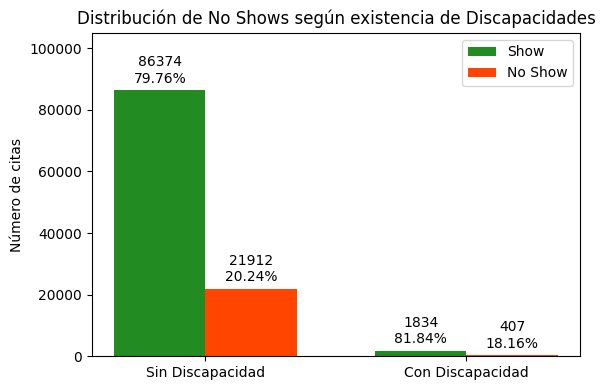

In [59]:
# Análisis distribución de No-shows según 'Handicap'
dist = med_app.groupby(['Handicap', 'NoShow'])['NoShow'].value_counts().reset_index()
dist_NoShows = dist.pivot(index='Handicap', columns='NoShow', values='count')

# Creación de la figura
fig,ax = plt.subplots(figsize = (6, 4))

# Configuración posición y grosor de las barras
x = np.arange(dist_NoShows.shape[0])
width = 0.35
offsets = np.linspace(-width/2, width/2, len(dist_NoShows.columns))

# Creación de todas las Barras
rects_list = []
labels = ['Show', 'No Show']
colors =['forestgreen', 'orangered']
for i, (no_show, counts) in enumerate(dist_NoShows.items()):
    rects_list.append(ax.bar(x = x + offsets[i],
                            height = counts,
                            width = width,
                            label = labels[i],
                            color = colors[i]))

# Configuración de las etiquetas dentro de las barras
for i in range(2):
    for j in range(2):
        height = rects_list[i][j].get_height()
        total_height = sum(rects_list[k][j].get_height() for k in range(2))
        ax.annotate(f'{height}\n{height/total_height:.2%}',
                    xy = (rects_list[i][j].get_x() + width/2, height),
                    xytext = (0, 25), textcoords = "offset points",
                    ha = 'center', va = 'top')

# Configuración de ejes y título
ax.set_ylabel('Número de citas')
ax.set_title("Distribución de No Shows según existencia de Discapacidades")
ax.set_xticks(x, ['Sin Discapacidad',
                    'Con Discapacidad'])
ax.legend(loc='upper right')
ax.set_ylim(0, 105000)

plt.tight_layout()
plt.show()

In [60]:
Diabetes_format = med_app['Handicap'].dtype
print(f"Tras el cambio en la variable, ahora sólo hay \033[1m{med_app['Handicap'].nunique()} \
valores de 'Handicap' distintos\033[0m:\n \
Sin Discapacidad: {med_app['Handicap'].unique()[0]} \n \
Con Discapacidad: {med_app['Handicap'].unique()[1]} \n \
expresados en números enteros {Diabetes_format}.\n")

NUMBER_NO_HANDICAP_APPs = med_app[med_app['Handicap'] == 0].shape[0]
NUMBER_WITH_HANDICAP_APPs = med_app[med_app['Handicap'] == 1].shape[0]

print("Y distribuidos de la siguiente forma:")
print(f"\tSin Discapacidad: '{med_app['Handicap'].unique()[0]}' = {NUMBER_NO_HANDICAP_APPs} citas = \
{NUMBER_NO_HANDICAP_APPs / NUMBER_SAMPLES:.4%}.")
print(f"\tCon Discapacidad: '{med_app['Handicap'].unique()[1]}' = {NUMBER_WITH_HANDICAP_APPs} citas = \
{NUMBER_WITH_HANDICAP_APPs / NUMBER_SAMPLES:.4%}.")

Tras el cambio en la variable, ahora sólo hay 2 valores de 'Handicap' distintos:
 Sin Discapacidad: 0 
 Con Discapacidad: 1 
 expresados en números enteros int64.

Y distribuidos de la siguiente forma:
	Sin Discapacidad: '0' = 108286 citas = 97.9724%.
	Con Discapacidad: '1' = 2241 citas = 2.0276%.


**ESTA VARIABLE PREDICTORA SIGUE ESTANDO FUERTEMENTE DESBALANCEADA**

## 1.14 Análisis 13ª característica: Recepción de SMS **'SMS_received'**.

In [61]:
Diabetes_format = med_app['SMS_received'].dtype
print(f"Hay \033[1m{med_app['SMS_received'].nunique()} \
valores de SMS Recibido distintos\033[0m:\n \
{med_app['SMS_received'].unique()}, \
expresados por 2 números enteros {Diabetes_format}.\n")

NUMBER_NO_SMS_APPs = med_app[med_app['SMS_received'] == 0].shape[0]
NUMBER_SMS_APPs = med_app[med_app['SMS_received'] == 1].shape[0]
print("Y distribuidos de la siguiente forma:")
print(f"\tSin SMS Recibidos: '{med_app['SMS_received'].unique()[0]}' = {NUMBER_NO_SMS_APPs} citas = \
{NUMBER_NO_SMS_APPs / NUMBER_SAMPLES:.2%}.")
print(f"\tCon 1 o más SMS Recibidos: '{med_app['SMS_received'].unique()[1]}' = {NUMBER_SMS_APPs} citas = \
{NUMBER_SMS_APPs / NUMBER_SAMPLES:.2%}.")

Hay 2 valores de SMS Recibido distintos:
 [0 1], expresados por 2 números enteros int64.

Y distribuidos de la siguiente forma:
	Sin SMS Recibidos: '0' = 75045 citas = 67.90%.
	Con 1 o más SMS Recibidos: '1' = 35482 citas = 32.10%.


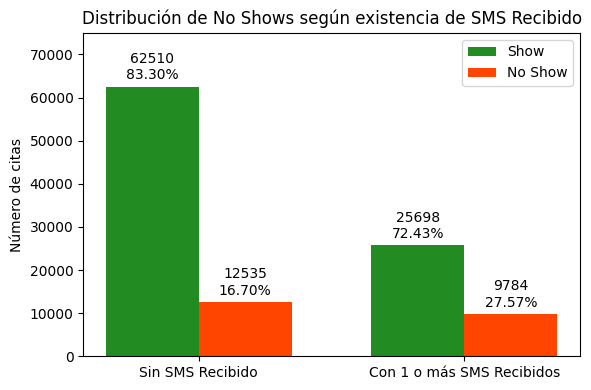

In [62]:
# Análisis distribución de No-shows según 'SMS_received'
dist = med_app.groupby(['SMS_received', 'NoShow'])['NoShow'].value_counts().reset_index()
dist_NoShows = dist.pivot(index='SMS_received', columns='NoShow', values='count')

# Creación de la figura
fig,ax = plt.subplots(figsize = (6, 4))

# Configuración posición y grosor de las barras
x = np.arange(len(dist_NoShows.columns))
width = 0.35
offsets = np.linspace(-width/2, width/2, len(dist_NoShows.columns))

# Creación de todas las Barras
rects_list = []
labels = ['Show', 'No Show']
colors =['forestgreen', 'orangered']
for i, (no_show, counts) in enumerate(dist_NoShows.items()):
    rects_list.append(ax.bar(x = x + offsets[i],
                            height = counts,
                            width = width,
                            label = labels[i],
                            color = colors[i]))

# Configuración de las etiquetas dentro de las barras
for i in range(2):
    for j in range(2):
        height = rects_list[i][j].get_height()
        total_height = sum(rects_list[k][j].get_height() for k in range(2))
        ax.annotate(f'{height}\n{height/total_height:.2%}',
                    xy = (rects_list[i][j].get_x() + width/2, height),
                    xytext = (0, 25), textcoords = "offset points",
                    ha = 'center', va = 'top')

# Configuración de ejes y título
ax.set_ylabel('Número de citas')
ax.set_title("Distribución de No Shows según existencia de SMS Recibido")
ax.set_xticks(x, ['Sin SMS Recibido', 'Con 1 o más SMS Recibidos'])
ax.legend(loc='upper right')
ax.set_ylim(0, 75000)

plt.tight_layout()
plt.show()

**ESTA VARIABLE PREDICTORA ESTÁ DESBALANCEADA**

**CONTRARIO A LO QUE PARECE LÓGICO, EXISTE MÁS INASISTENCIA ENTRE LOS PACIENTES QUE RECIBEN SMS DE RECORDATORIO QUE CON LOS PACIENTES QUE NO LOS RECIBEN**

Aunque esto también puede guardar una correlación encubierta con el margen temporal entre la fecha de programación de cita y la fecha de atención a cita propiamente. Existen mucho más citas a corto plazo (solicitadas el mismo día que se atiende) que citas a medio-largo plazo, y la Inasistencia a las citas solicitadas a corto plazo es mucho menor (4,66% vs 28,52%). Hay que estudiar la relación entre envíos de SMS y los márgenes temporales de asistencia mencionados.

*(Se hace más adelante, una vez creada dicha variable en Feature Engineering)*

# **2- Feature Engineering**

Eliminamos variables, las transformamos, o creamos nuevas, en función de hipótesis que se consideren potencialmente factibles de afectar a la asistencia o no de un paciente a una cita.

In [63]:
# Creación de una copia del dataset original
med_app_FE = med_app.copy()

## 2.1 Nuevas variables predictoras a partir de las fechas de solicitudes y asistencias a citas

En referencia a los tiempos, consideramos que las siguientes características pueden tener afectación a la asistencia:

- Día de la semana que se atiende la cita.
- Tiempo que ha pasado desde que se solicitó la cita.
- Tiempo que ha pasado desde que se atendió la última cita (en caso de no ser la primera).

### 2.1.1 Día de la semana que se atiende la cita: **'App_DayOfWeek'**

In [64]:
# Cálculo e inserción de la variable del día de la semana en que se atiende la cita:
med_app_FE.insert(loc = 5,
                    column = 'App_DayOfWeek',
                    value = med_app_FE['AppointmentDay'].dt.day_name())

print(f"Insertada nueva variable 'App_DayOfWeek' (Día de Cita) con \
{med_app_FE['App_DayOfWeek'].nunique()} valores:")
print(f"\t{med_app_FE['App_DayOfWeek'].unique()}")
print(f"Guardados en {med_app_FE['App_DayOfWeek'].dtype} string.")


Insertada nueva variable 'App_DayOfWeek' (Día de Cita) con 6 valores:
	['Friday' 'Wednesday' 'Monday' 'Thursday' 'Tuesday' 'Saturday']
Guardados en object string.


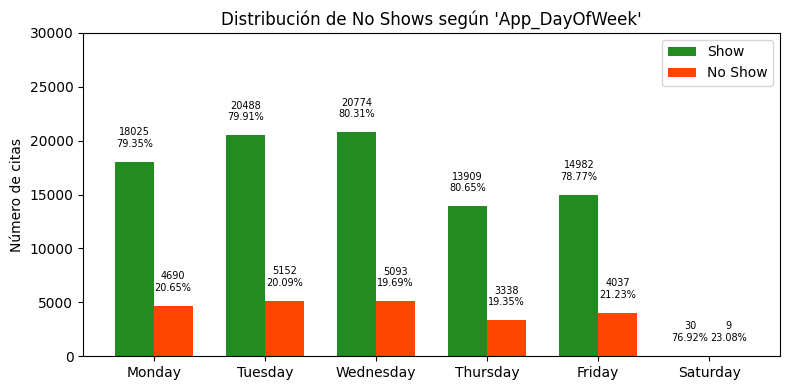

In [65]:
# Análisis distribución de No-shows según 'App_DayOfWeek'
dist = med_app_FE.groupby(['App_DayOfWeek', 'NoShow'])['NoShow'].value_counts().reset_index()
dist_NoShows = dist.pivot(index='App_DayOfWeek', columns='NoShow', values='count')
dist_NoShows['orden_personalizado'] = [4, 0, 5, 3, 1, 2]
dist_NoShows = dist_NoShows.sort_values('orden_personalizado')
dist_NoShows.drop(columns = ['orden_personalizado'], inplace = True)

# Creación de la figura
fig,ax = plt.subplots(figsize = (8, 4))

# Configuración posición y grosor de las barras
x = np.arange(dist_NoShows.shape[0])
width = 0.35
offsets = np.linspace(-width/2, width/2, dist_NoShows.shape[1])

# Creación de todas las Barras
rects_list = []
labels = ['Show', 'No Show']
colors =['forestgreen', 'orangered']
for i, (no_show, counts) in enumerate(dist_NoShows.items()):
    rects_list.append(ax.bar(x = x + offsets[i],
                            height = counts,
                            width = width,
                            label = labels[i],
                            color = colors[i]))

# Configuración de las etiquetas dentro de las barras
for i in range(dist_NoShows.shape[1]):
    for j in range(dist_NoShows.shape[0]):
        height = rects_list[i][j].get_height()
        total_height = sum(rects_list[k][j].get_height() for k in range(dist_NoShows.shape[1]))
        ax.annotate(f'{height}\n{height/total_height:.2%}',
                    fontsize = 7,
                    xy = (rects_list[i][j].get_x() + width/2, height),
                    xytext = (0, 25), textcoords = "offset points",
                    ha = 'center', va = 'top')

# Configuración de ejes y título
ax.set_ylabel('Número de citas')
ax.set_title("Distribución de No Shows según 'App_DayOfWeek'")
ax.set_xticks(x, dist_NoShows.index)
ax.legend(loc='upper right')
ax.set_ylim(0, 30000)

plt.tight_layout()
plt.show()

Los sábado tienen ínfima representatividad, sólo 39 citas.

Se procede a eliminar dichas citas para evitar meter ruido en el dataset.

In [66]:
med_app_FE.drop(labels = med_app_FE[med_app_FE['App_DayOfWeek'] == 'Saturday'].index,
                axis = 0,
                inplace = True)

In [67]:
# Cálculo e inserción de la variable del día de la semana en que se atiende la cita:
print(f"Tras los cambios aplicado, la variable 'App_DayOfWeek' (Día de Cita) tiene \
{med_app_FE['App_DayOfWeek'].nunique()} valores:")
print(f"\t{med_app_FE['App_DayOfWeek'].unique()}")
print(f"Guardados en {med_app_FE['App_DayOfWeek'].dtype} string.")


Tras los cambios aplicado, la variable 'App_DayOfWeek' (Día de Cita) tiene 5 valores:
	['Friday' 'Wednesday' 'Monday' 'Thursday' 'Tuesday']
Guardados en object string.


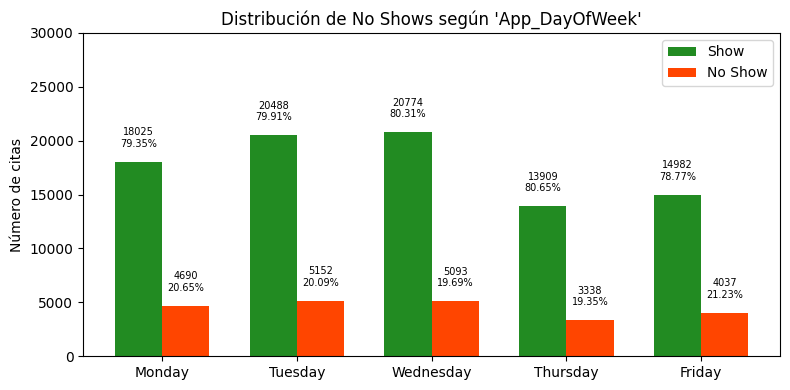

In [68]:
# Análisis distribución de No-shows según 'App_DayOfWeek'
dist = med_app_FE.groupby(['App_DayOfWeek', 'NoShow'])['NoShow'].value_counts().reset_index()
dist_NoShows = dist.pivot(index='App_DayOfWeek', columns='NoShow', values='count')
dist_NoShows['orden_personalizado'] = [4, 0, 3, 1, 2]
dist_NoShows = dist_NoShows.sort_values('orden_personalizado')
dist_NoShows.drop(columns = ['orden_personalizado'], inplace = True)

# Creación de la figura
fig,ax = plt.subplots(figsize = (8, 4))

# Configuración posición y grosor de las barras
x = np.arange(dist_NoShows.shape[0])
width = 0.35
offsets = np.linspace(-width/2, width/2, dist_NoShows.shape[1])

# Creación de todas las Barras
rects_list = []
labels = ['Show', 'No Show']
colors =['forestgreen', 'orangered']
for i, (no_show, counts) in enumerate(dist_NoShows.items()):
    rects_list.append(ax.bar(x = x + offsets[i],
                            height = counts,
                            width = width,
                            label = labels[i],
                            color = colors[i]))

# Configuración de las etiquetas dentro de las barras
for i in range(dist_NoShows.shape[1]):
    for j in range(dist_NoShows.shape[0]):
        height = rects_list[i][j].get_height()
        total_height = sum(rects_list[k][j].get_height() for k in range(dist_NoShows.shape[1]))
        ax.annotate(f'{height}\n{height/total_height:.2%}',
                    fontsize = 7,
                    xy = (rects_list[i][j].get_x() + width/2, height),
                    xytext = (0, 25), textcoords = "offset points",
                    ha = 'center', va = 'top')

# Configuración de ejes y título
ax.set_ylabel('Número de citas')
ax.set_title("Distribución de No Shows según 'App_DayOfWeek'")
ax.set_xticks(x, dist_NoShows.index)
ax.legend(loc='upper right')
ax.set_ylim(0, 30000)

plt.tight_layout()
plt.show()

### 2.1.2 Tiempo que ha pasado desde que se solicitó la cita: **'Time_SchDay_to_AppDay'**

In [69]:
# Cálculo e inserción de la variable del tiempo que ha pasado desde que se solicitó la cita:
med_app_FE.insert(loc = 6,
                    column = 'Time_SchDay_to_AppDay',
                    value = (med_app_FE['AppointmentDay'] - med_app_FE['ScheduledDay']).dt.total_seconds())

# Cambio del formato type de los valores de Datetime a Int
med_app_FE['Time_SchDay_to_AppDay'] = med_app_FE['Time_SchDay_to_AppDay'].astype('int64')

NUMBER_samples_neg_time = med_app_FE[med_app_FE['Time_SchDay_to_AppDay'] < 86400].shape[0]
MIN_TIME = med_app_FE['Time_SchDay_to_AppDay'].min()
MAX_TIME = med_app_FE['Time_SchDay_to_AppDay'].max()

print(f"Insertada nueva variable 'Time_SchDay_to_AppDay' (Tiempo entre Solicitud y Día de Cita),\n \
guardada en números enteros {med_app_FE['Time_SchDay_to_AppDay'].dtype}, \
que van desde {MIN_TIME} segundos hasta {MAX_TIME} segundos.\n")
print(f"\033[1m ¿Hay {NUMBER_samples_neg_time} citas en que se pide la cita después de asistir?\033[0m.")

Insertada nueva variable 'Time_SchDay_to_AppDay' (Tiempo entre Solicitud y Día de Cita),
 guardada en números enteros int64, que van desde -568160 segundos hasta 15427141 segundos.

 ¿Hay 43772 citas en que se pide la cita después de asistir?.


In [70]:
# Extracción de citas con extrañas programaciones de más de un día después de la cita
bizarre_scheduled = med_app_FE[med_app_FE['Time_SchDay_to_AppDay'] <= -86400]
bizarre_scheduled

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,App_DayOfWeek,Time_SchDay_to_AppDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,NoShow
72362,3787481966821,5655637,M,2016-05-04 06:50:57,2016-05-03,Tuesday,-111057,7,TABUAZEIRO,0,0,0,0,0,0,True
27033,7839272661752,5679978,M,2016-05-10 10:51:53,2016-05-09,Monday,-125513,38,RESISTÊNCIA,0,0,0,0,1,0,True
55226,7896293967868,5715660,F,2016-05-18 14:50:41,2016-05-17,Tuesday,-139841,19,SANTO ANTÔNIO,0,0,0,0,1,0,True
64175,24252258389979,5664962,F,2016-05-05 13:43:58,2016-05-04,Wednesday,-135838,22,CONSOLAÇÃO,0,0,0,0,0,0,True
71533,998231581612122,5686628,F,2016-05-11 13:49:20,2016-05-05,Thursday,-568160,81,SANTO ANTÔNIO,0,0,0,0,0,0,True


Estas 5 citas tienen ScheduledDay muy extraños, cón más de un día de retraso respecto el AppointmentDay, **y a las 5 citas no asistieron.**

Cómo son muestras de la clase desbalanceada preferimos no deshacernos de ellas, así que asumimos que fueron errores de dedo en la recogida de datos y que en realidad el ScheduledDay fue el mismo que el AppointmentDay.

Lo mismo podemos considerar del resto de citas con Time_Before_AppDay negativo, ya que dicho número negativo es fruto de que no tenemos datos de HORA del AppointmentDay, así que el sistema considera que se han tenido todas a las 00:00:00.

In [71]:
# Corrección a 0's de todos los 'Time_SchDay_to_AppDay' negativos:
med_app_FE['Time_SchDay_to_AppDay'][med_app_FE['Time_SchDay_to_AppDay'] <= 0] = 0

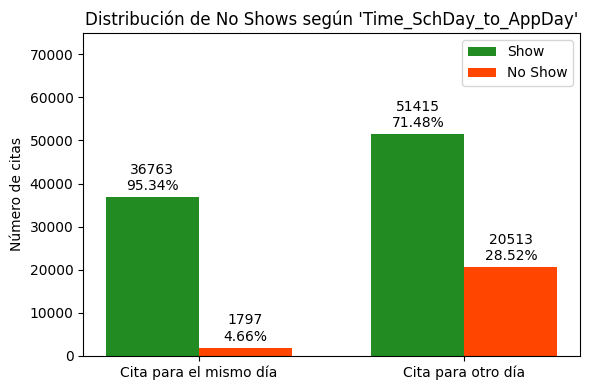

In [72]:
# Análisis distribución de No-shows según 'Time_SchDay_to_AppDay'
dist = med_app_FE.groupby([med_app_FE['Time_SchDay_to_AppDay']>0,
                            'NoShow']
                        )['NoShow'].value_counts().reset_index()
dist_NoShows = dist.pivot(index='Time_SchDay_to_AppDay', columns='NoShow', values='count')

# Creación de la figura
fig,ax = plt.subplots(figsize = (6, 4))

# Configuración posición y grosor de las barras
x = np.arange(len(dist_NoShows.columns))
width = 0.35
offsets = np.linspace(-width/2, width/2, len(dist_NoShows.columns))

# Creación de todas las Barras
rects_list = []
labels = ['Show', 'No Show']
colors =['forestgreen', 'orangered']
for i, (no_show, counts) in enumerate(dist_NoShows.items()):
    rects_list.append(ax.bar(x = x + offsets[i],
                            height = counts,
                            width = width,
                            label = labels[i],
                            color = colors[i]))

# Configuración de las etiquetas dentro de las barras
for i in range(2):
    for j in range(2):
        height = rects_list[i][j].get_height()
        total_height = sum(rects_list[k][j].get_height() for k in range(2))
        ax.annotate(f'{height}\n{height/total_height:.2%}',
                    xy = (rects_list[i][j].get_x() + width/2, height),
                    xytext = (0, 25), textcoords = "offset points",
                    ha = 'center', va = 'top')

# Configuración de ejes y título
ax.set_ylabel('Número de citas')
ax.set_title("Distribución de No Shows según 'Time_SchDay_to_AppDay'")
ax.set_xticks(x, ['Cita para el mismo día', 'Cita para otro día'])
ax.legend(loc='upper right')
ax.set_ylim(0, 75000)

plt.tight_layout()
plt.show()

**EXISTE UNA GRAN CORRELACIÓN ENTRE LA FALTA DE ASISTENCIA A LA CITA Y EL TIEMPO DE ANTELACIÓN CON LA QUE SE SOLICITA.**

**Revisión de la variable 'SMS_received' en función de 'Time_SchDay_to_AppDay':**

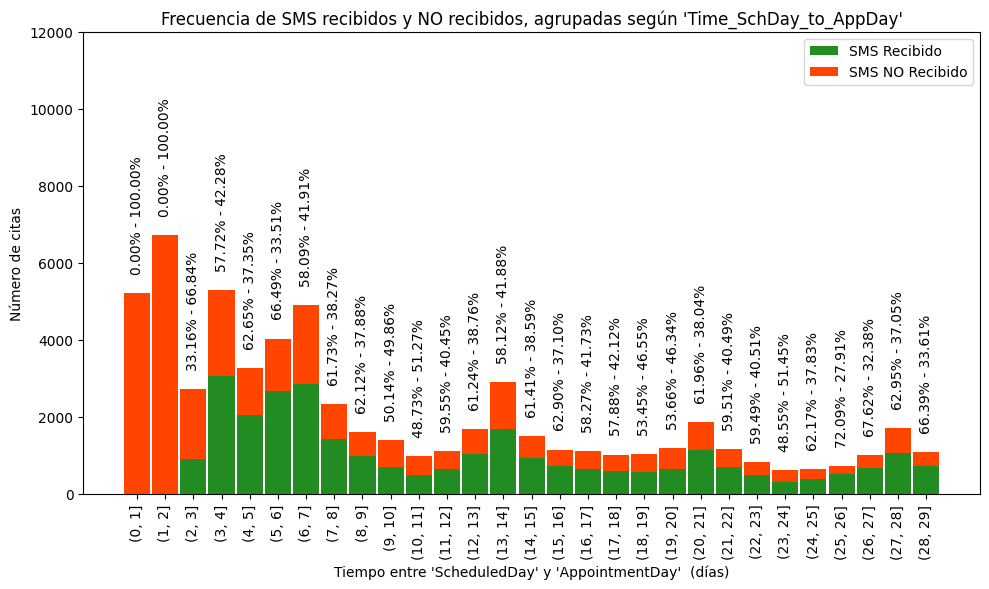

In [73]:
# Distribución de los tiempos entre 'ScheduledDay' y 'AppointmentDay' en grupos de 1 día
Time_groups = pd.cut(med_app_FE['Time_SchDay_to_AppDay'], bins = range(0, 30*24*60*60, 24*60*60))

# Calcular el número de citas para cada grupo de tiempos
Time_groups_count = Time_groups.value_counts().sort_index()

# Guardar las posiciones en el eje x de cada una de las barras
Time_xticks = Time_groups_count.index.map(lambda x: x.right)

# Guardar las etiquetas de los grupos de edades
Time_xticks_labels = [f"({x.left/86400:.0f}, {x.right/86400:.0f}]" for x in Time_groups_count.index]

# Cálculo del número de citas con 'SMS_received' por grupo de tiempo
count_SMS_received_byTime = med_app_FE[med_app_FE['SMS_received'] == True].groupby(Time_groups).size()
count_SMS_no_received_byTime = med_app_FE[med_app_FE['SMS_received'] == False].groupby(Time_groups).size()

# Crear el gráfico
plt.figure(figsize = (10, 6))

# Barras de 'SMS Recibido'
plt.bar(x = Time_xticks,
        height = count_SMS_received_byTime,
        width = 80000,
        label = 'SMS Recibido',
        color = 'forestgreen')

# Barras de 'SMS No Recibido', apiladas sobre las de 'SMS Recibido'
plt.bar(x = Time_xticks,
        height = count_SMS_no_received_byTime,
        width = 80000,
        bottom = count_SMS_received_byTime[count_SMS_no_received_byTime.index],
        label = 'SMS NO Recibido',
        color = 'orangered')

# Etiquetas de las barras (% de 'SMS Recibidos' y 'SMS No Recibidos')
for group in Time_xticks:
    SMS_received_percent = count_SMS_received_byTime[group] / Time_groups_count[group]
    SMS_no_received_percent = count_SMS_no_received_byTime[group] / Time_groups_count[group]
    plt.text(x = group,
            y = Time_groups_count[group] + 500,
            s = f'{SMS_received_percent:.2%} - {SMS_no_received_percent:.2%}',
            ha = 'center',
            va = 'bottom',
            rotation = 90)

# Configuración títulos de gráfico y ejes, etiquetas del eje x, y leyenda
plt.xlabel("Tiempo entre 'ScheduledDay' y 'AppointmentDay'  (días)")
plt.ylabel("Número de citas")
plt.title("Frecuencia de SMS recibidos y NO recibidos, agrupadas según 'Time_SchDay_to_AppDay'")
plt.xticks(ticks = Time_xticks,
            labels = Time_xticks_labels,
            rotation = 90)
plt.legend()

plt.ylim(0, 12000)
plt.tight_layout()
plt.show()

**En el gráfico anterior se verifica la teoría de que la correlación entre 'SMS_received' y 'NoShow' está condicionada por el tiempo existente entre el día en que se solicita la cita y el que se atiende, es decir, la variable 'Time_SchDay_to_AppDay'.**

**Cuando se solicita una cita para el mismo día o el siguiente, nunca se envía SMS**, sin embargo, las tasas de asistencia son mucho mayores, lo que afecta a la correlación 'SMS_received' y 'NoShow'.

### 2.1.3 Tiempo que ha pasado desde que se atendió la última cita: **'Days_since_last_App'**

In [74]:
# Cálculo e inserción de la variable del tiempo entre citas de un mismo paciente
med_app_FE.insert(loc = 7,
                    column = 'Days_since_last_App',
                    value = med_app_FE.groupby('PatientId')['AppointmentDay'].diff().dt.days)

# Asignación -1 a todos las citas de pacientes que no han tenido citas previas
med_app_FE['Days_since_last_App'].fillna(-1, inplace=True)

# Cambio del formato type de los valores de Datetime a Int
med_app_FE['Days_since_last_App'] = med_app_FE['Days_since_last_App'].astype('int64')

MIN_TIME = med_app_FE['Days_since_last_App'].min()
MAX_TIME = med_app_FE['Days_since_last_App'].max()

print(f"Insertada nueva variable 'Days_since_last_App' (Días entre Citas Consecutivas),\n \
guardada en números enteros {med_app_FE['Days_since_last_App'].dtype}, \
que va desde {MIN_TIME} días,\n cuando se trata de la 1a cita de un paciente, \
hasta {MAX_TIME} días.")

Insertada nueva variable 'Days_since_last_App' (Días entre Citas Consecutivas),
 guardada en números enteros int64, que va desde -1 días,
 cuando se trata de la 1a cita de un paciente, hasta 40 días.


## 2.2 Nuevas variables predictoras a partir de la información sobre los barrios

En referencia a los barrios, se considera que pueden ser información relevante las siguientes características:

- Situación geográfica de los barrios, o agrupación por clústers (con el objetivo de disminuir el sesgo en esta variable).
- Existencia de Centros de Salud en el mismo barrio.

*Otra buena información sería la distancia desde el domicilio del paciente hasta su Centro de Salud asignado, pero no hay forma de conseguirla.*

In [75]:
# Exportación de una Serie con los nombres de los barrios a un archivo Excel
neigh_unique_sorted = sorted(med_app_FE['Neighbourhood'].unique())
neigh_df = pd.DataFrame(neigh_unique_sorted, columns=['Neighbourhood'])
neigh_df.to_excel('Neighbourhoods.xlsx', index=False)

Mediante la información geográfica de los barrios de Brasil obtenida en https://github.com/alanwillms/geoinfo, y de las unidades de salud obtenida en https://www.vitoria.es.gov.br/cidadao/servicos-para-a-pessoa-idosa#a_listaunidadesdesaude, se extrae la información contenida en el fichero excel 'Neighbourhoods Brazil.xlsx'.

NOTA: HealthCentre recoge si el barrio tiene (1) o no (0) un centro de salud.

In [76]:
neigh_geo_data = pd.read_excel('Neighbourhoods Brazil.xlsx')

In [77]:
# Cálculo e inserción de la variable de número de citas por cada barrio
dict_num_apps = med_app_FE.groupby('Neighbourhood').size().to_dict()

neigh_geo_data.insert(loc = 7,
                        column = 'Number_Apps_byNeigh',
                        value = neigh_geo_data['Neighbourhood'].map(dict_num_apps))

In [78]:
neigh_geo_data

,Neighbourhood,LatitudeNeigh,LongitudeNeigh,HealthCentre,LatitudeHealthCentre,LongitudeHealthCentre,NameHealthCentre,Number_Apps_byNeigh
0,AEROPORTO,-20.258100,-40.286400,0,NaN,NaN,NaN,8
1,ANDORINHAS,-20.287964,-40.305672,1,-20.290608,-40.306925,Unidade de Saúde - Andorinhas - Dr. Luis Claud...,2262
2,ANTÔNIO HONÓRIO,-20.263121,-40.298013,0,NaN,NaN,NaN,271
3,ARIOVALDO FAVALESSA,-20.314683,-40.356385,0,NaN,NaN,NaN,277
4,BARRO VERMELHO,-20.294978,-40.298013,0,NaN,NaN,NaN,423
...,...,...,...,...,...,...,...,...
76,SÃO JOSÉ,-20.284160,-40.330555,0,NaN,NaN,NaN,1977
77,SÃO PEDRO,-20.281962,-40.336296,1,-20.280093,-40.337114,Unidade de Saúde - Ilha das Caieiras - Vereado...,2448
78,TABUAZEIRO,-20.294411,-40.322262,1,-20.292430,-40.321464,Unidade de Saúde - São Cristovão,3132
79,UNIVERSITÁRIO,-20.295603,-40.340123,0,NaN,NaN,NaN,152


In [79]:
# CREACIÓN MAPA CON LA CLUSTERIZACIÓN DE BARRIOS Y SEÑALIZACIÓN DE CENTROS DE SALUD

# Selección las características de entrada para el clustering
coord_neigh = neigh_geo_data[['LatitudeNeigh', 'LongitudeNeigh']].values

# Definición del número de clusters deseado
n_clusters = 12

# Iniciación y ajuste del modelo de K-Means para los barrios
kmeans_neigh = KMeans(n_clusters = n_clusters, random_state = 10)
kmeans_neigh.fit(coord_neigh)

# Adición de las etiquetas de cluster al DataFrame original de los barrios
neigh_geo_data['Cluster'] = kmeans_neigh.labels_

# Definición de un diccionario de colores para cada cluster
cluster_colors = {0: 'blue',
                    1: 'green',
                    2: 'purple',
                    3: 'orange',
                    4: 'pink',
                    5: 'gray',
                    6: 'black',
                    7: 'darkgreen',
                    8: 'darkblue',
                    9: 'lightblue',
                    10: 'lightgreen',
                    11: 'lightgray'}

# Creación del mapa
map_clusters = folium.Map(location=[neigh_geo_data['LatitudeNeigh'].mean(),
                                    neigh_geo_data['LongitudeNeigh'].mean()],
                            zoom_start = 13)

# Adición de un grupo de marcadores para los barrios al mapa
marker_cluster_neigh = MarkerCluster().add_to(map_clusters)
# Asignación de los marcadores para cada barrio, con el color correspondientes a su cluster
for index, row in neigh_geo_data.iterrows():
    folium.Marker(location = [row['LatitudeNeigh'], row['LongitudeNeigh']],
                    popup = f"Neighbourhood: {row['Neighbourhood']}<br> \
                    Cluster: {row['Cluster']}<br> \
                    Número de Citas: {row['Number_Apps_byNeigh']}",
                    icon = folium.Icon(color=cluster_colors[row['Cluster']], icon='Home')
                    ).add_to(marker_cluster_neigh)

# Adición del grupo de marcadores para los centros de salud al mapa
marker_cluster_health_centres = MarkerCluster().add_to(map_clusters)
# Asignación de los marcadores para cada centro de salud
for index, row in neigh_geo_data.iterrows():
    if pd.notnull(row['LatitudeHealthCentre']) and pd.notnull(row['LongitudeHealthCentre']):
        folium.Marker(location = [row['LatitudeHealthCentre'], row['LongitudeHealthCentre']],
                        popup = f"Health Centre: {row['NameHealthCentre']}<br>",
                        icon = folium.Icon(color='red', icon='plus-sign')
                        ).add_to(marker_cluster_health_centres)

# Guardar el mapa en un archivo HTML
map_clusters.save("map_BAD_KMeans_12clusters_with_HealthCentres.html")

El mapa anterior muestra una agrupación de los barrios por proximidad, y la situación de los centros de salud.

Sin embargo, procedemos a ajustar manualmente la asignación de barrios para balancear mejor el número de muestras por Cluster de Barrios.

In [80]:
# Corrección de barrios en los Cluster para ajustar promedio de número de citas similar
neigh_geo_data.loc[neigh_geo_data['Neighbourhood'] == 'NOVA PALESTINA', 'Cluster'] = 2
neigh_geo_data.loc[neigh_geo_data['Neighbourhood'] == 'REDENÇÃO', 'Cluster'] = 2
neigh_geo_data.loc[neigh_geo_data['Neighbourhood'] == 'CONQUISTA', 'Cluster'] = 2
neigh_geo_data.loc[neigh_geo_data['Neighbourhood'] == 'INHANGUETÁ', 'Cluster'] = 3
neigh_geo_data.loc[neigh_geo_data['Neighbourhood'] == 'BELA VISTA', 'Cluster'] = 3
neigh_geo_data.loc[neigh_geo_data['Neighbourhood'] == 'BENTO FERREIRA', 'Cluster'] = 4
neigh_geo_data.loc[neigh_geo_data['Neighbourhood'] == 'PRAIA DO CANTO', 'Cluster'] = 4
neigh_geo_data.loc[neigh_geo_data['Neighbourhood'] == 'BARRO VERMELHO', 'Cluster'] = 8
neigh_geo_data.loc[neigh_geo_data['Neighbourhood'] == 'GOIABEIRAS', 'Cluster'] = 9
neigh_geo_data.loc[neigh_geo_data['Neighbourhood'] == 'DA PENHA', 'Cluster'] =11

In [81]:
# CREACIÓN DE UN NUEVO MAPA CON LA CLUSTERIZACIÓN DE BARRIOS CORREGIDO
map_clusters = folium.Map(location=[neigh_geo_data['LatitudeNeigh'].mean(),
                                    neigh_geo_data['LongitudeNeigh'].mean()],
                            zoom_start = 13)

# Adición de un grupo de marcadores para los barrios al mapa
marker_cluster_neigh = MarkerCluster().add_to(map_clusters)
# Asignación de los marcadores para cada barrio, con el color correspondientes a su cluster
for index, row in neigh_geo_data.iterrows():
    folium.Marker(location = [row['LatitudeNeigh'], row['LongitudeNeigh']],
                    popup = f"Neighbourhood: {row['Neighbourhood']}<br> \
                    Cluster: {row['Cluster']}<br> \
                    Número de Citas: {row['Number_Apps_byNeigh']}",
                    icon = folium.Icon(color=cluster_colors[row['Cluster']], icon='Home')
                    ).add_to(marker_cluster_neigh)

# Adición del grupo de marcadores para los centros de salud al mapa
marker_cluster_health_centres = MarkerCluster().add_to(map_clusters)
# Asignación de los marcadores para cada centro de salud
for index, row in neigh_geo_data.iterrows():
    if pd.notnull(row['LatitudeHealthCentre']) and pd.notnull(row['LongitudeHealthCentre']):
        folium.Marker(location = [row['LatitudeHealthCentre'], row['LongitudeHealthCentre']],
                        popup = f"Health Centre: {row['NameHealthCentre']}<br>",
                        icon = folium.Icon(color='red', icon='plus-sign')
                        ).add_to(marker_cluster_health_centres)

# Guardar el mapa en un archivo HTML
map_clusters.save("map_GOOD_KMeans_12clusters_with_HealthCentres.html")

### 2.2.1 Clúster de pertenencia de cada barrio: **'Neigh_Cluster'**

In [82]:
# Asignación e inserción de la variable del cluster correspondiente a cada barrio
dict_clusters = neigh_geo_data.set_index('Neighbourhood')['Cluster'].to_dict()

med_app_FE.insert(loc = 10,
                    column = 'Neigh_Cluster',
                    value = med_app_FE['Neighbourhood'].map(dict_clusters))

print(f"Insertada nueva variable 'Neigh_Cluster' (Agrupación de Barrios por Proximidad),\n \
agrupados en {med_app_FE['Neigh_Cluster'].nunique()} clusters: \
{sorted(med_app_FE['Neigh_Cluster'].unique())},\n \
y guardada en números enteros {med_app_FE['Neigh_Cluster'].dtype}.")

Insertada nueva variable 'Neigh_Cluster' (Agrupación de Barrios por Proximidad),
 agrupados en 12 clusters: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 y guardada en números enteros int64.


(12,)


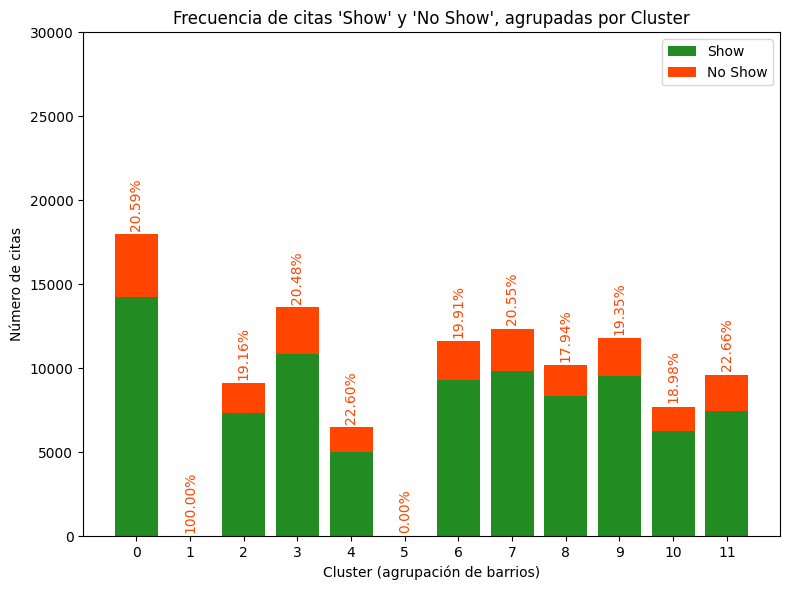

In [83]:
# Serie con la contabilidad de las Citas realizadas en cada Cluster de barrios:
Cluster_count = med_app_FE['Neigh_Cluster'].value_counts()

# Cálculo del número de citas 'Show' y 'No Show' por Cluster de barrio:
count_shows_byCluster = med_app_FE[med_app_FE['NoShow'] == False] \
        .groupby(med_app_FE['Neigh_Cluster']).size()
count_no_shows_byCluster = med_app_FE[med_app_FE['NoShow'] == True] \
        .groupby(med_app_FE['Neigh_Cluster']).size()

# Reindexar para asegurar que ambos DataFrames tengan los mismos índices
combined_index = count_shows_byCluster.index.union(count_no_shows_byCluster.index)
count_shows_byCluster = count_shows_byCluster.reindex(combined_index, fill_value=0)
count_no_shows_byCluster = count_no_shows_byCluster.reindex(combined_index, fill_value=0)

# Crear el gráfico
plt.figure(figsize = (8, 6))

# Barras de 'Shows'
ax = plt.bar(x = count_shows_byCluster.index,
        height = count_shows_byCluster,
        label = 'Show',
        color = 'forestgreen')
print(count_shows_byCluster.index.shape)

# Barras de 'No Shows', apiladas sobre las de Shows
plt.bar(x = count_no_shows_byCluster.index,
        height = count_no_shows_byCluster,
        bottom = count_shows_byCluster[count_no_shows_byCluster.index],
        label = 'No Show',
        color = 'orangered')

# Etiquetas de las barras
for cluster in count_shows_byCluster.index:
        no_shows_percent = count_no_shows_byCluster[cluster] / Cluster_count[cluster]
        plt.text(x = cluster,
                y = Cluster_count[cluster]+200,
                s = f'{no_shows_percent:.2%}',
                ha = 'center',
                va = 'bottom',
                rotation = 90,
                color = 'orangered')

# Configuración títulos de gráfico y ejes, y leyenda
plt.xlabel("Cluster (agrupación de barrios)")
plt.xticks(Cluster_count.index)
plt.ylabel("Número de citas")
plt.title("Frecuencia de citas 'Show' y 'No Show', agrupadas por Cluster")
plt.legend()

plt.ylim(0, 30000)
plt.tight_layout()
plt.show()

La gráfica anterior muestra el número de citas por Cluster de barrios, una vez agrupados según proximidad.

Los Cluster 1 y 5 los descartamos, ya que sólo tienen 2 y 1 muestras, respectivamente. Así que procedemos a eliminar dichas citas:

In [84]:
# Eliminación de los 2 clusters con una o dos cita:
indexes = med_app_FE.loc[(med_app_FE['Neigh_Cluster'] == 1) | \
                        (med_app_FE['Neigh_Cluster'] == 5)
                        ].index.tolist()

med_app_FE.drop(indexes, inplace = True)

# Corremos todos los valores de los cluster del 0 al 9:
for i in range(2, 12):
    if i < 6:
        med_app_FE.loc[med_app_FE['Neigh_Cluster'] == i, 'Neigh_Cluster'] = i-1
    else:
        med_app_FE.loc[med_app_FE['Neigh_Cluster'] == i, 'Neigh_Cluster'] = i-2

### 2.2.2 Existencia de Centro de Salud en el barrio: **'Health_Centre'**

In [85]:
# Inserción de la variable de existencia de Centro Médico en cada barrio
dict_health_centres = neigh_geo_data.set_index('Neighbourhood')['HealthCentre'].to_dict()

med_app_FE.insert(loc = 11,
                    column = 'Health_Centre',
                    value = med_app_FE['Neighbourhood'].map(dict_health_centres))

print(f"Insertada nueva variable 'Health_Centre' (Existencia de Centro Médico en el Barrio),\n \
indicando su existencia (1) o no (0), \
y guardada en números enteros {med_app_FE['Health_Centre'].dtype}.")

Insertada nueva variable 'Health_Centre' (Existencia de Centro Médico en el Barrio),
 indicando su existencia (1) o no (0), y guardada en números enteros int64.


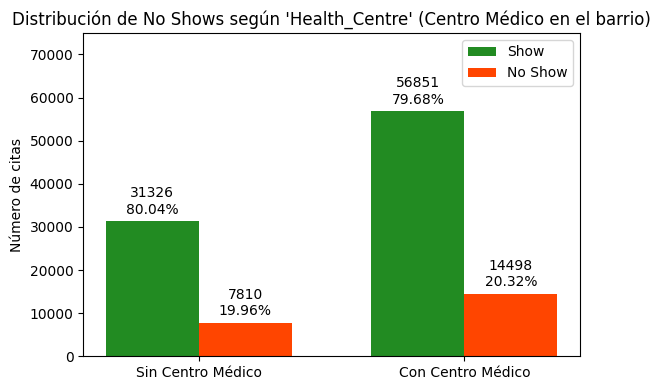

In [86]:
# Análisis distribución de No-shows según 'Health_Centre'
dist = med_app_FE.groupby(['Health_Centre', 'NoShow'])['NoShow'].value_counts().reset_index()
dist_NoShows = dist.pivot(index='Health_Centre', columns='NoShow', values='count')

# Creación de la figura
fig,ax = plt.subplots(figsize = (6, 4))

# Configuración posición y grosor de las barras
x = np.arange(len(dist_NoShows.columns))
width = 0.35
offsets = np.linspace(-width/2, width/2, len(dist_NoShows.columns))

# Creación de todas las Barras
rects_list = []
labels = ['Show', 'No Show']
colors =['forestgreen', 'orangered']
for i, (no_show, counts) in enumerate(dist_NoShows.items()):
    rects_list.append(ax.bar(x = x + offsets[i],
                            height = counts,
                            width = width,
                            label = labels[i],
                            color = colors[i]))

# Configuración de las etiquetas dentro de las barras
for i in range(2):
    for j in range(2):
        height = rects_list[i][j].get_height()
        total_height = sum(rects_list[k][j].get_height() for k in range(2))
        ax.annotate(f'{height}\n{height/total_height:.2%}',
                    xy = (rects_list[i][j].get_x() + width/2, height),
                    xytext = (0, 25), textcoords = "offset points",
                    ha = 'center', va = 'top')

# Configuración de ejes y título
ax.set_ylabel('Número de citas')
ax.set_title("Distribución de No Shows según 'Health_Centre' (Centro Médico en el barrio)")
ax.set_xticks(x, ['Sin Centro Médico', 'Con Centro Médico'])
ax.legend(loc='upper right')
ax.set_ylim(0, 75000)

plt.tight_layout()
plt.show()

**Los pacientes son más responsables (atienden más citas) cuando no tienen Centro Médico en el barrio.**

## 2.3 Nuevas variables predictoras a partir de condiciones climáticas del día de la cita

Otra hipótesis muy razonable es que la asistencia a la cita médica venga muy condicionada por la meteorología de ese día en cuestión, es decir, la temperatura, viento y lluvia.

Para ello se extrae dicha información de la web y se incorpora al dataset.

In [87]:
# Lectura de los datos meteorológicos en Victoria para el mes de 
climate_data = pd.read_excel('Weather and Climate Brazil.xlsx')

climate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           41 non-null     datetime64[ns]
 1   Temperature    41 non-null     float64       
 2   WindSpeed      41 non-null     float64       
 3   Precipitation  41 non-null     float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.4 KB


In [88]:
climate_data.head()

,Date,Temperature,WindSpeed,Precipitation
0,2016-04-29,24.03,10.45,0.94
1,2016-04-30,27.16,6.27,0.21
2,2016-05-01,24.03,14.62,0.42
3,2016-05-02,24.03,13.58,0.00
4,2016-05-03,25.07,9.40,0.00


### 2.3.1 / 2.3.2 / 2.3.3 Temperatura: **'Temperature'**  /  Velocidad del viento: **'Wind_Speed'**  /  Lluvia: **'Precipitation'**

In [89]:
# Combinación de los datasets utilizando el campo AppointmentDay de med_app_FE y el campo Date de climate_data.
columns = ['Temperature', 'WindSpeed', 'Precipitation']
med_app_FE = med_app_FE.merge(climate_data,
                                left_on='AppointmentDay',
                                right_on='Date',
                                how='left')

med_app_FE.drop(columns = 'Date', inplace = True )

# Reubicación de las columnas
columns = ['PatientId',
            'AppointmentID',
            'Gender',
            'ScheduledDay',
            'AppointmentDay',
            'App_DayOfWeek',
            'Time_SchDay_to_AppDay',
            'Days_since_last_App',
            'Age',
            'Neighbourhood',
            'Neigh_Cluster',
            'Health_Centre',
            'Temperature',
            'WindSpeed',
            'Precipitation',
            'Scholarship',
            'Hypertension',
            'Diabetes',
            'Alcoholism',
            'Handicap',
            'SMS_received',
            'NoShow']

med_app_FE = med_app_FE.reindex(columns = columns)

In [90]:
med_app_FE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110485 entries, 0 to 110484
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   PatientId              110485 non-null  int64         
 1   AppointmentID          110485 non-null  int64         
 2   Gender                 110485 non-null  object        
 3   ScheduledDay           110485 non-null  datetime64[ns]
 4   AppointmentDay         110485 non-null  datetime64[ns]
 5   App_DayOfWeek          110485 non-null  object        
 6   Time_SchDay_to_AppDay  110485 non-null  int64         
 7   Days_since_last_App    110485 non-null  int64         
 8   Age                    110485 non-null  int64         
 9   Neighbourhood          110485 non-null  object        
 10  Neigh_Cluster          110485 non-null  int64         
 11  Health_Centre          110485 non-null  int64         
 12  Temperature            110485 non-null  floa

In [91]:
med_app_FE.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,App_DayOfWeek,Time_SchDay_to_AppDay,Days_since_last_App,Age,Neighbourhood,...,Temperature,WindSpeed,Precipitation,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,NoShow
0,39217,5751990,F,2016-05-31 10:56:41,2016-06-03,Friday,219799,-1,44,PRAIA DO SUÁ,...,28.20,7.31,0.10,0,0,0,0,0,0,False
1,43741,5760144,M,2016-06-01 14:22:58,2016-06-01,Wednesday,0,-1,39,MARIA ORTIZ,...,29.25,8.36,0.00,0,0,1,0,0,0,False
2,93779,5712759,F,2016-05-18 09:12:29,2016-05-18,Wednesday,0,-1,33,CENTRO,...,26.11,4.18,0.10,0,0,0,0,0,0,False
3,141724,5637648,M,2016-04-29 07:13:36,2016-05-02,Monday,233184,-1,12,FORTE SÃO JOÃO,...,24.03,13.58,0.00,0,0,0,0,0,0,False
4,537615,5637728,F,2016-04-29 07:19:57,2016-05-06,Friday,578403,-1,14,FORTE SÃO JOÃO,...,26.11,8.36,0.31,0,0,0,0,0,1,False


## 2.4 Nuevas variables predictoras a partir de la información del historial médico

En referencia al historial médico de cada paciente, el análisis EDA arrojó una correlación muy baja entre la existencia de una de las dolencias médicas presentes en el Dataset (Hipertensión, Diabetes, Alcoholismo o Discapacidad) y la asistencia o no a las citas concertadas.

Aun así, se considera que una combinación de ellas puede ganar relevancia en la predicción, por lo que se procede a crear otra variable que indique la presencia o el número de patologías presentes en cada paciente.

### 2.4.1 Presencia de dolencias médicas presentes en el paciente: **'Presence_Health_Conds'**

Primero hacemos el análisis del número de dolencia médicas que puede llegar a atener cada paciente.

In [92]:
# Cálculo del número de dolencias médicas: 'Number_Health_Conds'
num_Health_Conds = med_app_FE['Hypertension'] + \
                    med_app_FE['Diabetes'] + \
                    med_app_FE['Alcoholism'] +\
                    (med_app_FE['Handicap'] > 0).astype(int)

med_app_FE.insert(loc = 20,
                    column = 'Number_Health_Conds',
                    value = num_Health_Conds)

MIN_num_Health_Conds = med_app_FE['Number_Health_Conds'].min()
MAX_num_Health_Conds = med_app_FE['Number_Health_Conds'].max()

print(f"Insertada variable 'Number_Health_Conds' (Número de Dolencias Médicas por Paciente),\n \
variando entre {MIN_num_Health_Conds} y {MAX_num_Health_Conds} dolencias médicas en un sólo paciente,\n \
y guardada en números enteros {med_app_FE['Number_Health_Conds'].dtype}.")

Insertada variable 'Number_Health_Conds' (Número de Dolencias Médicas por Paciente),
 variando entre 0 y 4 dolencias médicas en un sólo paciente,
 y guardada en números enteros int64.


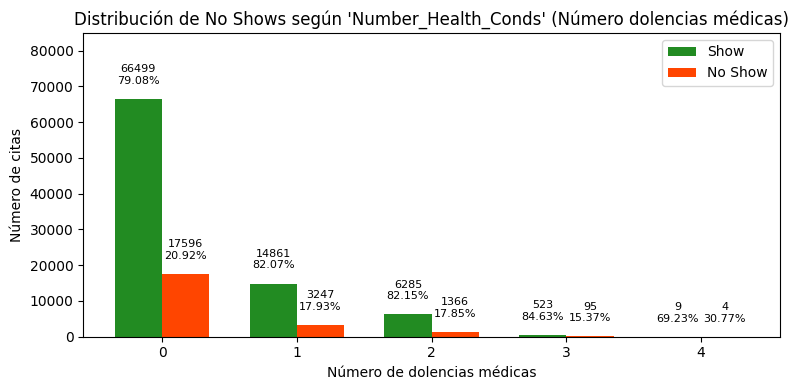

In [93]:
# Análisis distribución de No-shows según 'Number_Health_Conds'
dist = med_app_FE.groupby(['Number_Health_Conds', 'NoShow'])['NoShow'].value_counts().reset_index()
dist_NoShows = dist.pivot(index='Number_Health_Conds', columns='NoShow', values='count')

# Creación de la figura
fig,ax = plt.subplots(figsize = (8, 4))

# Configuración posición y grosor de las barras
x = np.arange(dist_NoShows.shape[0])
width = 0.35
offsets = np.linspace(-width/2, width/2, dist_NoShows.shape[1])

# Creación de todas las Barras
rects_list = []
labels = ['Show', 'No Show']
colors =['forestgreen', 'orangered']
for i, (no_show, counts) in enumerate(dist_NoShows.items()):
    rects_list.append(ax.bar(x = x + offsets[i],
                            height = counts,
                            width = width,
                            label = labels[i],
                            color = colors[i]))

# Configuración de las etiquetas dentro de las barras
for i in range(dist_NoShows.shape[1]):
    for j in range(dist_NoShows.shape[0]):
        height = rects_list[i][j].get_height()
        total_height = sum(rects_list[k][j].get_height() for k in range(dist_NoShows.shape[1]))
        ax.annotate(f'{height}\n{height/total_height:.2%}',
                    fontsize = 8,
                    xy = (rects_list[i][j].get_x() + width/2, height),
                    xytext = (0, 25), textcoords = "offset points",
                    ha = 'center', va = 'top')

# Configuración de ejes y título
ax.set_xlabel('Número de dolencias médicas')
ax.set_ylabel('Número de citas')
ax.set_title("Distribución de No Shows según 'Number_Health_Conds' (Número dolencias médicas)")
ax.set_xticks(x, dist_NoShows.index)
ax.legend(loc='upper right')
ax.set_ylim(0, 85000)

plt.tight_layout()
plt.show()

Normalmente los pacientes tienen una tasa de asistencia mejor a medida que presentan mayores dolencias médicas.

Sin embargo, *si el paciente presenta las 4 dolencias al mismo tiempo, se dispara la probabilidad de inasistencia.*

**SIN EMBARGO, LA REPRESENTATIVIDAD DE LAS CITAS CON TODAS LAS DOLENCIAS MÉDICAS ES ÍNFIMA, POR LO QUE PROCEDEMOS A AGRUPAR ESTA VARIABLE EN SÓLO DOS VALORES:**

- '0': Sin dolencia alguna
- '1': Con 1 o más dolencias médicas (Hipertensión, Diabetes, Alcoholismo o Discapacidad).

In [94]:
# Se agrupa todas las citas en un único grupo de citas con pacientes que tengan al menos una cita médica
med_app_FE.loc[med_app_FE['Number_Health_Conds'] != 0, 'Number_Health_Conds'] = 1

# Se renombra la variable a 'Presence_Heath_Cond'
med_app_FE.rename(columns = {'Number_Health_Conds': 'Presence_Health_Conds'},
                    inplace = True)

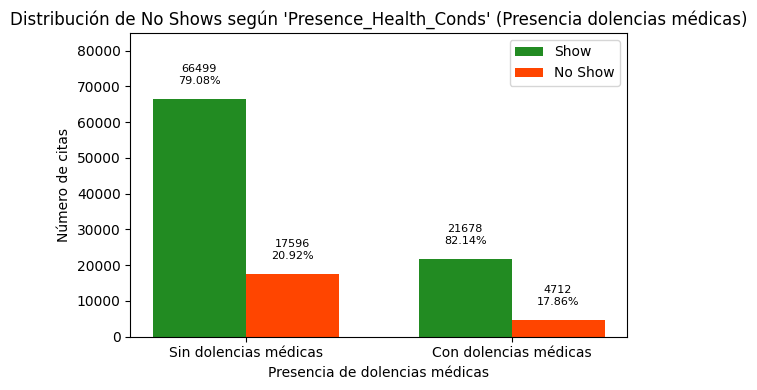

In [99]:
# Análisis distribución de No-shows según 'Presence_Health_Conds'
dist = med_app_FE.groupby(['Presence_Health_Conds', 'NoShow'])['NoShow'].value_counts().reset_index()
dist_NoShows = dist.pivot(index='Presence_Health_Conds', columns='NoShow', values='count')

# Creación de la figura
fig,ax = plt.subplots(figsize = (6, 4))

# Configuración posición y grosor de las barras
x = np.arange(dist_NoShows.shape[0])
width = 0.35
offsets = np.linspace(-width/2, width/2, dist_NoShows.shape[1])

# Creación de todas las Barras
rects_list = []
labels = ['Show', 'No Show']
colors =['forestgreen', 'orangered']
for i, (no_show, counts) in enumerate(dist_NoShows.items()):
    rects_list.append(ax.bar(x = x + offsets[i],
                            height = counts,
                            width = width,
                            label = labels[i],
                            color = colors[i]))

# Configuración de las etiquetas dentro de las barras
for i in range(dist_NoShows.shape[1]):
    for j in range(dist_NoShows.shape[0]):
        height = rects_list[i][j].get_height()
        total_height = sum(rects_list[k][j].get_height() for k in range(dist_NoShows.shape[1]))
        ax.annotate(f'{height}\n{height/total_height:.2%}',
                    fontsize = 8,
                    xy = (rects_list[i][j].get_x() + width/2, height),
                    xytext = (0, 25), textcoords = "offset points",
                    ha = 'center', va = 'top')

# Configuración de ejes y título
ax.set_xlabel('Presencia de dolencias médicas')
ax.set_ylabel('Número de citas')
ax.set_title("Distribución de No Shows según 'Presence_Health_Conds' (Presencia dolencias médicas)")
ax.set_xticks(x, ['Sin dolencias médicas', 'Con dolencias médicas'])
ax.legend(loc='upper right')
ax.set_ylim(0, 85000)

plt.tight_layout()
plt.show()

In [100]:
print(f"Insertada nueva variable 'Presence_Health_Conds' \
(Presencia de Dolencias Médicas en Paciente), la cual varía entre:\n \
{med_app_FE['Presence_Health_Conds'].unique()[0]} = Sin dolencias médicas\n \
{med_app_FE['Presence_Health_Conds'].unique()[1]} = Con al menos una dolencia médica\n \
guardada en números enteros {med_app_FE['Presence_Health_Conds'].dtype}.")

Insertada nueva variable 'Presence_Health_Conds' (Presencia de Dolencias Médicas en Paciente), la cual varía entre:
 0 = Sin dolencias médicas
 1 = Con al menos una dolencia médica
 guardada en números enteros int64.


## 2.5 Nuevas variables predictoras a partir de la información de asistencias previas de un paciente.

En referencia al historial de asistencias de cada paciente, se considera relevante a la hora de determinar la probabilidad de asistencia del mismo las siguientes dos estadísticas:

- Número de citas previas del mismo paciente.
- Número de NoShows previos en cada paciente.
- Probabilidad de NoShow en función de la asistencia a las citas previas del mismo paciente.

### 2.5.1 Número de citas previas de un paciente: **'Prior_Apps_byPatient'**

In [101]:
# Cálculo del número de citas previas por paciente: 'Prior_Apps_byPatient'
med_app_FE.insert(loc = 22,
                    column = 'Prior_Apps_byPatient',
                    value = med_app_FE.groupby('PatientId').cumcount())

MIN_prior_apps = med_app_FE['Prior_Apps_byPatient'].min()
MAX_prior_apps = med_app_FE['Prior_Apps_byPatient'].max()

print(f"Insertada nueva variable 'Prior_Apps_byPatient' \
(Número de Citas Previas por Paciente),\n \
variando entre {MIN_prior_apps} (primera cita) y \
{MAX_prior_apps} citas previas del mismo paciente,\n \
y guardada en números enteros {med_app_FE['Prior_Apps_byPatient'].dtype}.")

Insertada nueva variable 'Prior_Apps_byPatient' (Número de Citas Previas por Paciente),
 variando entre 0 (primera cita) y 87 citas previas del mismo paciente,
 y guardada en números enteros int64.


### 2.5.2 Número de No Asistencias a citas previas de un paciente: **'Prior_NoShows_byPatient'**

In [102]:
# Cálculo del número de NoShows previo de cada paciente:
med_app_FE.insert(loc = 23,
                    column = 'Prior_NoShows_byPatient',
                    value = med_app_FE.groupby('PatientId')['NoShow'].cumsum())

# El valor anterior tiene en cuenta el NoShow de la cita actual,
# para no tenerla en cuenta, se mueven los valores una fila hacia abajo:
med_app_FE['Prior_NoShows_byPatient'] = med_app_FE.groupby('PatientId')['Prior_NoShows_byPatient'] \
                                            .transform(lambda x: x.shift(periods = 1,
                                                                        fill_value = 0))

MIN_prior_NoShows = med_app_FE['Prior_NoShows_byPatient'].min()
MAX_prior_NoShows = med_app_FE['Prior_NoShows_byPatient'].max()

print(f"Insertada nueva variable 'Prior_NoShows_byPatient' \
(Número de No Asistencias a Citas Previas por Paciente),\n \
variando entre {MIN_prior_NoShows} y {MAX_prior_NoShows} No Shows previos del mismo paciente,\n \
y guardada en números enteros {med_app_FE['Prior_NoShows_byPatient'].dtype}.")

Insertada nueva variable 'Prior_NoShows_byPatient' (Número de No Asistencias a Citas Previas por Paciente),
 variando entre 0 y 17 No Shows previos del mismo paciente,
 y guardada en números enteros int64.


### 2.5.3 Porcentaje de No Asistencia del paciente basado en citas previas del mismo paciente: **'Prob_NoShow_byPatient'**

In [103]:
# Inicialización e inserción de la nueva columna 'Prob_NoShow_byPatient' con el valor promedio de Asistencia en el Dataset
med_app_FE.insert(loc = 24,
                    column = 'Prob_NoShow_byPatient',
                    value = NUMBER_NO_SHOWS / NUMBER_SAMPLES)

# Actualización de la probabilidad de asistencia en función de los NoShows en citas previas:
for patient in med_app_FE['PatientId'].unique():
    indexes = med_app_FE[med_app_FE['PatientId'] == patient].index
    for i in range(1, len(indexes)):
        prob_anterior = med_app_FE.loc[indexes[i-1], 'Prob_NoShow_byPatient']
        prob_actual = med_app_FE.loc[indexes[i], 'Prior_NoShows_byPatient'] / \
                        med_app_FE.loc[indexes[i], 'Prior_Apps_byPatient']   # type: ignore
        med_app_FE.loc[indexes[i], 'Prob_NoShow_byPatient'] = (prob_anterior + prob_actual) / 2

MIN_prob_NoShow = med_app_FE['Prob_NoShow_byPatient'].min()
MAX_prob_NoShow = med_app_FE['Prob_NoShow_byPatient'].max()

print(f"Insertada nueva variable 'Prob_NoShow_byPatient'\n \
(Probabilidad de NoShow en función de la asistencia a las citas previas de un mismo Paciente),\n \
variando entre un {MIN_prob_NoShow:.4%} y un {MAX_prob_NoShow:.4%}, \
y guardada en números reales {med_app_FE['Prob_NoShow_byPatient'].dtype}.")

Insertada nueva variable 'Prob_NoShow_byPatient'
 (Probabilidad de NoShow en función de la asistencia a las citas previas de un mismo Paciente),
 variando entre un 0.0000% y un 99.9994%, y guardada en números reales float64.


In [104]:
# Visualización del paciente con mayor probabilidad de No Asistencia en función de sus NoShows previos:
patient_ids = med_app_FE[med_app_FE['Prob_NoShow_byPatient'] == MAX_prob_NoShow]['PatientId'].values
print(f'El paciente con mayor probabilidad de No Asistencia,\n \
calculada en función de sus NoShows previos es: {patient_ids}.')

med_app_FE[med_app_FE['PatientId'] == patient_ids[0]][['PatientId',
                                                        'ScheduledDay',
                                                        'AppointmentDay',
                                                        'Prior_Apps_byPatient',
                                                        'Prior_NoShows_byPatient',
                                                        'Prob_NoShow_byPatient',
                                                        'NoShow']]


El paciente con mayor probabilidad de No Asistencia,
 calculada en función de sus NoShows previos es: [1421986987763].


,PatientId,ScheduledDay,AppointmentDay,Prior_Apps_byPatient,Prior_NoShows_byPatient,Prob_NoShow_byPatient,NoShow
19099,1421986987763,2016-05-04 15:50:42,2016-05-04,0,0,0.201933,True
19100,1421986987763,2016-05-04 15:51:21,2016-05-04,1,1,0.600966,True
19101,1421986987763,2016-05-04 16:05:24,2016-05-04,2,2,0.800483,True
19102,1421986987763,2016-05-04 16:07:01,2016-05-04,3,3,0.900242,True
19103,1421986987763,2016-05-04 16:08:03,2016-05-04,4,4,0.950121,True
19104,1421986987763,2016-05-11 07:44:50,2016-05-11,5,5,0.975060,True
19105,1421986987763,2016-05-11 07:47:24,2016-05-11,6,6,0.987530,True
19106,1421986987763,2016-05-11 07:55:08,2016-05-11,7,7,0.993765,True
19107,1421986987763,2016-05-25 16:28:35,2016-05-25,8,8,0.996883,True
19108,1421986987763,2016-05-25 16:34:32,2016-05-25,9,9,0.998441,True


## 2.6 Conversión de todas las variables categóricas a numéricas usando **LabelEncoder**.

In [105]:
# Se instancia un nuevo LabelEncoder para cada columna categórica
gender_encoder = LabelEncoder()
App_DayOfWeek_encoder = LabelEncoder()
neighbourhood_encoder = LabelEncoder()

# Conversión de las variables categóricas a numéricas usando fit_transform
med_app_FE['Gender'] = gender_encoder.fit_transform(med_app_FE['Gender'])
med_app_FE['App_DayOfWeek'] = App_DayOfWeek_encoder.fit_transform(med_app_FE['App_DayOfWeek'])
med_app_FE['Neighbourhood'] = neighbourhood_encoder.fit_transform(med_app_FE['Neighbourhood'])

In [106]:
med_app_FE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110485 entries, 0 to 110484
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   PatientId                110485 non-null  int64         
 1   AppointmentID            110485 non-null  int64         
 2   Gender                   110485 non-null  int32         
 3   ScheduledDay             110485 non-null  datetime64[ns]
 4   AppointmentDay           110485 non-null  datetime64[ns]
 5   App_DayOfWeek            110485 non-null  int32         
 6   Time_SchDay_to_AppDay    110485 non-null  int64         
 7   Days_since_last_App      110485 non-null  int64         
 8   Age                      110485 non-null  int64         
 9   Neighbourhood            110485 non-null  int32         
 10  Neigh_Cluster            110485 non-null  int64         
 11  Health_Centre            110485 non-null  int64         
 12  Temperature     

In [107]:
med_app_FE

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,App_DayOfWeek,Time_SchDay_to_AppDay,Days_since_last_App,Age,Neighbourhood,...,Hypertension,Diabetes,Alcoholism,Handicap,Presence_Health_Conds,SMS_received,Prior_Apps_byPatient,Prior_NoShows_byPatient,Prob_NoShow_byPatient,NoShow
0,39217,5751990,0,2016-05-31 10:56:41,2016-06-03,0,219799,-1,44,54,...,0,0,0,0,0,0,0,0,0.201933,False
1,43741,5760144,1,2016-06-01 14:22:58,2016-06-01,4,0,-1,39,42,...,0,1,0,0,1,0,0,0,0.201933,False
2,93779,5712759,0,2016-05-18 09:12:29,2016-05-18,4,0,-1,33,10,...,0,0,0,0,0,0,0,0,0.201933,False
3,141724,5637648,1,2016-04-29 07:13:36,2016-05-02,1,233184,-1,12,23,...,0,0,0,0,0,0,0,0,0.201933,False
4,537615,5637728,0,2016-04-29 07:19:57,2016-05-06,0,578403,-1,14,23,...,0,0,0,0,0,1,0,0,0.201933,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110480,999931985292928,5772701,1,2016-06-03 16:04:03,2016-06-07,3,287757,13,90,36,...,0,0,0,0,0,1,4,0,0.012621,False
110481,999934989273974,5639453,1,2016-04-29 09:07:06,2016-04-29,0,0,-1,5,39,...,0,0,0,0,0,0,0,0,0.201933,False
110482,999946536742891,5649678,1,2016-05-03 07:08:13,2016-05-03,3,0,-1,65,75,...,1,0,0,0,1,0,0,0,0.201933,False
110483,999968578354866,5740680,0,2016-05-25 15:51:24,2016-05-25,4,0,-1,81,37,...,0,0,0,0,0,0,0,0,0.201933,False


## 2.7 Visualización de la **matriz de correlación** entre todas las variables, incluída la Target.

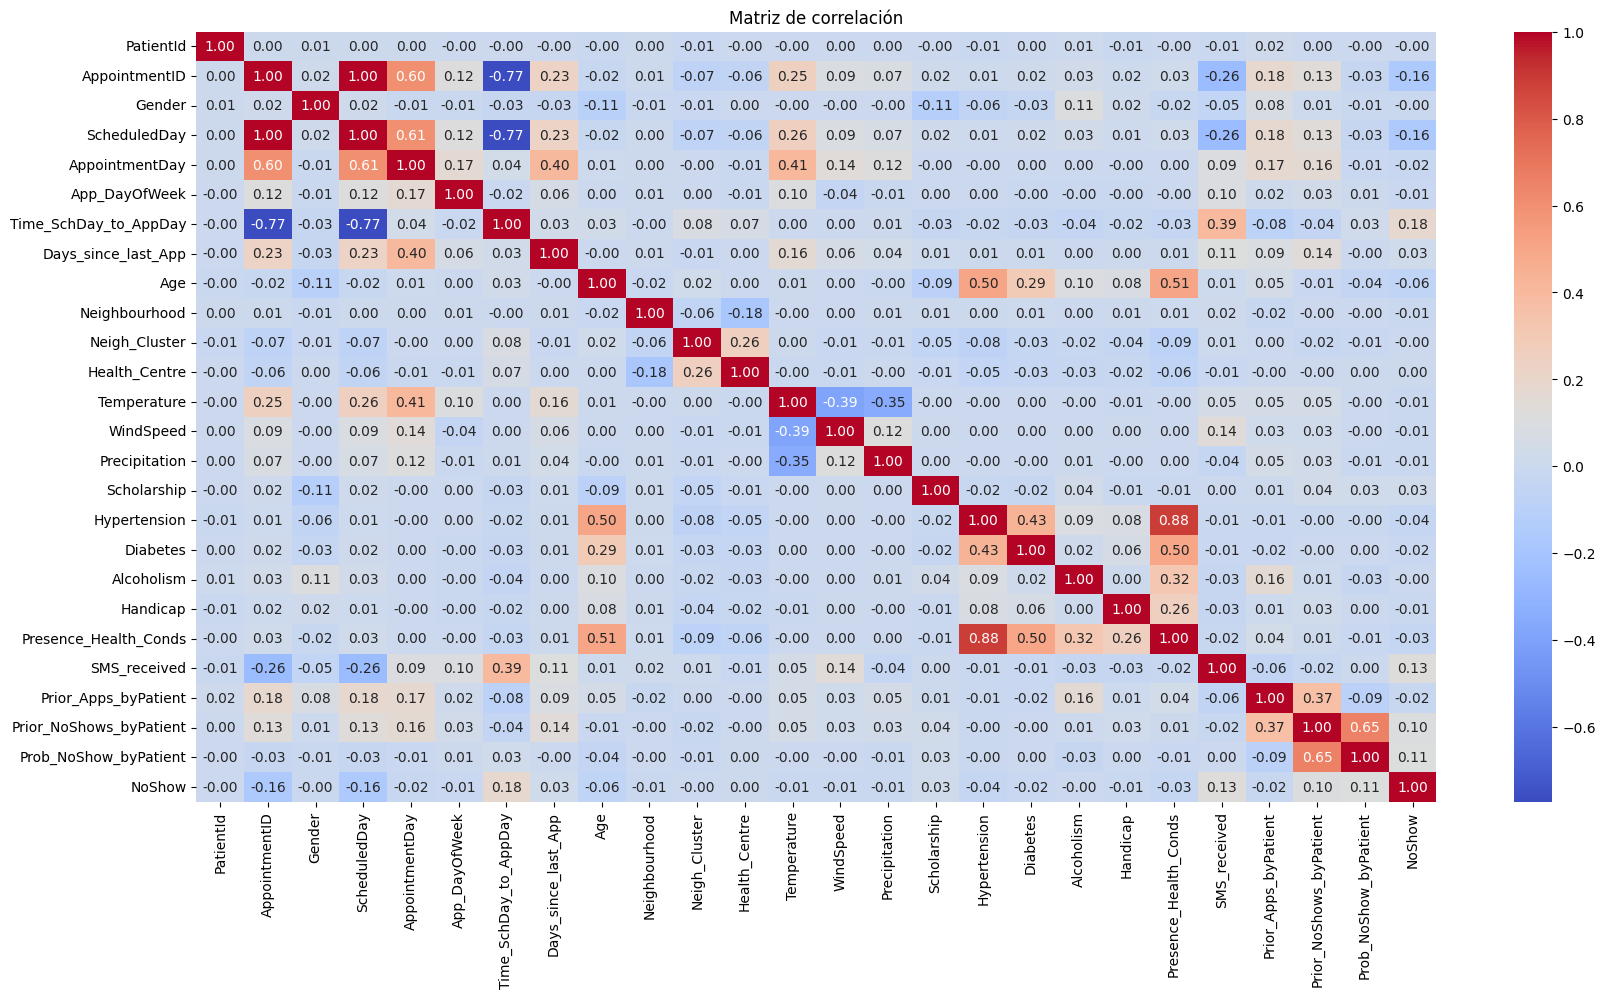

In [108]:
# Cálculo de la matriz de correlación
correlation = med_app_FE.corr()

# Visualización de la matriz de correlación con un mapa de calor
plt.figure(figsize=(20, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

## 2.8 Se guarda la información del Dataset antes de dividirlo entre Entrenamiento y Pruebas

In [110]:
# Exportar el DataFrame a archivos csv
med_app_FE.to_csv('med_app_FE.csv', index=False)

# Exportar el DataFrame a archivo Excel
med_app_FE.to_excel('med_app_FE.xlsx', index=False)

# **3- Conformación de los sets de entrenamiento y prueba**

## 3.1 División del dataset en los conjuntos de entrenamiento y prueba

La estructura del dataset Medical Appointments contiene un fuerte componente temporal, con la información de los pacientes que van asistiendo de forma regular a consulta médica.

Se divide el dataset de forma que el set de prueba corresponda sólo a las últimas citas de pacientes distintos, intentando que todos ellos tengan las citas asignadas al final del periodo temporal que comprende el dataset, manteniendo la misma estratificación de clases que en el dataset original.

In [111]:
NUMBER_Apps_inTest = int(NUMBER_SAMPLES * 0.20)
print(f"Para alcanzar el 20% del muestreo en nuestro set de pruebas\n \
necesitamos {NUMBER_Apps_inTest} citas de pacientes distintos, es decir,\n \
muestras de un {NUMBER_Apps_inTest / NUMBER_PATIENTS:.2%} de los pacientes.")

Para alcanzar el 20% del muestreo en nuestro set de pruebas
 necesitamos 22105 citas de pacientes distintos, es decir,
 muestras de un 35.48% de los pacientes.


In [114]:
# Creación del sub-dataset que contiene sólo la última cita de cada paciente 
last_app_byPatient = med_app_FE.groupby('PatientId').last()

# Ordenación por 'AppointmentDay'
last_app_byPatient = last_app_byPatient.sort_values(by = 'AppointmentDay')

# Cálculo del número de citas NoShow = True que se requieren para mantener la estratificación de Clases
NUMBER_NoShows_inTest = int(NUMBER_Apps_inTest * (NUMBER_NO_SHOWS / NUMBER_SAMPLES))
NUMBER_Shows_inTest = int(NUMBER_Apps_inTest - NUMBER_NoShows_inTest)
print(f"Se requieren {NUMBER_NoShows_inTest} pacientes con 'NoShow' = True en el Set de Prueba, y\n \
{NUMBER_Shows_inTest} pacientes con 'NoShow' = False.\n")

# Selección de las últimas 4463 muestras del sub-dataset 'last_app_byPatient' con 'NoShow' = True
test_set_NoShows = last_app_byPatient[last_app_byPatient['NoShow'] == True][-(NUMBER_NoShows_inTest+1):-1]

# Selección de las últimas 17642 muestras del sub-dataset 'last_app_byPatient' con 'NoShow' = False
test_set_Shows = last_app_byPatient[last_app_byPatient['NoShow'] == False][-(NUMBER_Shows_inTest+1):-1]

# Concatenación de ambos sub-dataset en el Set de Pruebas
test_set = pd.concat([test_set_NoShows, test_set_Shows])

# Selección del Set de Pruebas definitivo
test_set = med_app_FE[med_app_FE['AppointmentID'].isin(test_set['AppointmentID'])]
print(f"Creado Set de Prueba con {test_set.shape[0]} citas de \
{test_set['PatientId'].nunique()} pacientes distintos.")

# Selección del Set de Entrenamiento definitivo
train_set = med_app_FE[~med_app_FE['AppointmentID'].isin(test_set['AppointmentID'])]
print(f"Creado Set de Entrenamiento con {train_set.shape[0]} citas de \
{train_set['PatientId'].nunique()} pacientes distintos.")

Se requieren 4463 pacientes con 'NoShow' = True en el Set de Prueba, y
 17642 pacientes con 'NoShow' = False.

Creado Set de Prueba con 22105 citas de 22105 pacientes distintos.
Creado Set de Entrenamiento con 88380 citas de 52538 pacientes distintos.


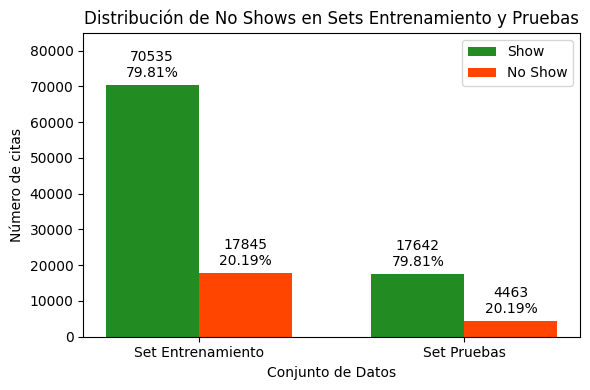

In [115]:
# Creación de la figura
fig,ax = plt.subplots(figsize = (6, 4))

# Configuración posición y de las barras
width = 0.35
offsets = np.linspace(-width/2, width/2, 2)

labels = ['Show', 'No Show']
colors =['forestgreen', 'orangered']

def create_bars(datasets):
    for pos, dataset in enumerate(datasets):
        class_counts = dataset['NoShow'].value_counts()
        rects_list = []
        for i, counts in enumerate(class_counts.values):
            rects_list.append(ax.bar(x = pos + offsets[i],
                                    height = counts,
                                    width = width,
                                    color = colors[i]))
            if pos == 1:  # Solo añadir la leyenda en la primera iteración
                rects_list[-1].set_label(labels[i])
            height = int(rects_list[i].datavalues)
            total_height = dataset.shape[0]
            ax.annotate(f'{height}\n{height/total_height:.2%}',
                        xy = (pos + offsets[i], height),
                        xytext = (0, 25), textcoords = "offset points",
                        ha = 'center', va = 'top')
    return

create_bars([train_set, test_set])

# Configuración de ejes y título
ax.set_xlabel('Conjunto de Datos')
ax.set_ylabel('Número de citas')
ax.set_title("Distribución de No Shows en Sets Entrenamiento y Pruebas")
ax.set_xticks([0, 1], ['Set Entrenamiento', 'Set Pruebas'])
ax.legend(loc='upper right')
ax.set_ylim(0, 85000)

plt.tight_layout()
plt.show()

## 3.2 Eliminación de las variables que no aportan información relevante

Se considera que las siguientes variables no contienen información relevante, por los motivos expuestos:

- **'AppointmentID'**: Número diferente asignado a cada cita, en función de la fechas de programación de cita.

  - *La correlación que se observa con la variable Target 'NoShows' (-0.16) es directamente proporcional a la correlación existente entre la diferencia de tiempo entre el 'AppointmentDay' y el 'ScheduledDay' ('Time_SchDay_to_AppDay') con 'NoShows', ya que las primeras citas programadas son las que tienen los números AppointmentID más bajos, y éstas coinciden con las que tienen el 'Time_SchDay_to_AppDay' más alto.*

- **'PatientId'**: Número diferente asignado a cada paciente. Dicho número es aleatorio.

- **ScheduledDay** y **'AppointmentDay**: Día de programación de la cita y de día de asignación de cita, respectivamente.

  - *Con el Feature Engineering ya se ha guardado toda la información relevante que contienen estas fechas*

- **'Neighbourhood'**: Barrio de residencia de cada paciente.

  - *Esta información ya se ha agrupado en la variable 'Neigh_Cluster'.*

- **SMS_received**: Variable que guarda información sobre la recepción o no de SMS recordatorio de asistencia a la cita, para cada cita.

  - *El envío de SMS's recordatorios es importante para disminuir las ausencias, pero no lo podemos usar como variable predictora en el algoritmo de predicción, ya que no se dispondrá dicha información en el momento de programación de la cita.*

In [116]:
# Definición de las variables que no aportan información:
columns_to_drop = ['AppointmentID',
                    'PatientId',
                    'ScheduledDay',
                    'AppointmentDay',
                    'Neighbourhood',
                    'SMS_received']

# En el set de entrenamiento:
train_set.drop(columns = columns_to_drop, inplace = True)
# En el set de pruebas:
test_set.drop(columns = columns_to_drop, inplace = True)

In [117]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88380 entries, 2 to 110484
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   88380 non-null  int32  
 1   App_DayOfWeek            88380 non-null  int32  
 2   Time_SchDay_to_AppDay    88380 non-null  int64  
 3   Days_since_last_App      88380 non-null  int64  
 4   Age                      88380 non-null  int64  
 5   Neigh_Cluster            88380 non-null  int64  
 6   Health_Centre            88380 non-null  int64  
 7   Temperature              88380 non-null  float64
 8   WindSpeed                88380 non-null  float64
 9   Precipitation            88380 non-null  float64
 10  Scholarship              88380 non-null  int64  
 11  Hypertension             88380 non-null  int64  
 12  Diabetes                 88380 non-null  int64  
 13  Alcoholism               88380 non-null  int64  
 14  Handicap                 8

In [118]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22105 entries, 0 to 110480
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   22105 non-null  int32  
 1   App_DayOfWeek            22105 non-null  int32  
 2   Time_SchDay_to_AppDay    22105 non-null  int64  
 3   Days_since_last_App      22105 non-null  int64  
 4   Age                      22105 non-null  int64  
 5   Neigh_Cluster            22105 non-null  int64  
 6   Health_Centre            22105 non-null  int64  
 7   Temperature              22105 non-null  float64
 8   WindSpeed                22105 non-null  float64
 9   Precipitation            22105 non-null  float64
 10  Scholarship              22105 non-null  int64  
 11  Hypertension             22105 non-null  int64  
 12  Diabetes                 22105 non-null  int64  
 13  Alcoholism               22105 non-null  int64  
 14  Handicap                 2

## 3.3 Se guarda la información de los Sets de Entrenamiento y Prueba, antes de separar etiquetas, estandarizar y balancear con SMOTE+ENN

In [119]:
# Exportar el DataFrame a archivos csv
train_set.to_csv('train_set.csv', index=False)
test_set.to_csv('test_set.csv', index=False)

# Exportar el DataFrame a archivo Excel
train_set.to_excel('train_set.xlsx', index=False)
test_set.to_excel('test_set.xlsx', index=False)

## 3.4 División de las variables predictoras de la variable target (etiquetas)

In [120]:
# Se divide el conjunto de entrenamiento en características y etiquetas
X_train_set = train_set.drop('NoShow', axis=1)
y_train_set = train_set['NoShow']
X_test_set = test_set.drop('NoShow', axis=1)
y_test_set = test_set['NoShow']

# **4- Últimas transformaciones de los datasets antes del entrenamiento**

## 4.1 Estandarización de las bases de datos

In [121]:
# Guardar los nombres de las columnas
column_names = X_train_set.columns

# Se crea una instancia de StandardScaler
scaler = StandardScaler()

# Se ajusta el escalador a los datos de entrenamiento y se transforman
X_train_scaled = scaler.fit_transform(X_train_set)
# Se transforman los datos de test utilizando el mismo escalador que se ajustó a los datos de entrenamiento
X_test_scaled = scaler.transform(X_test_set)

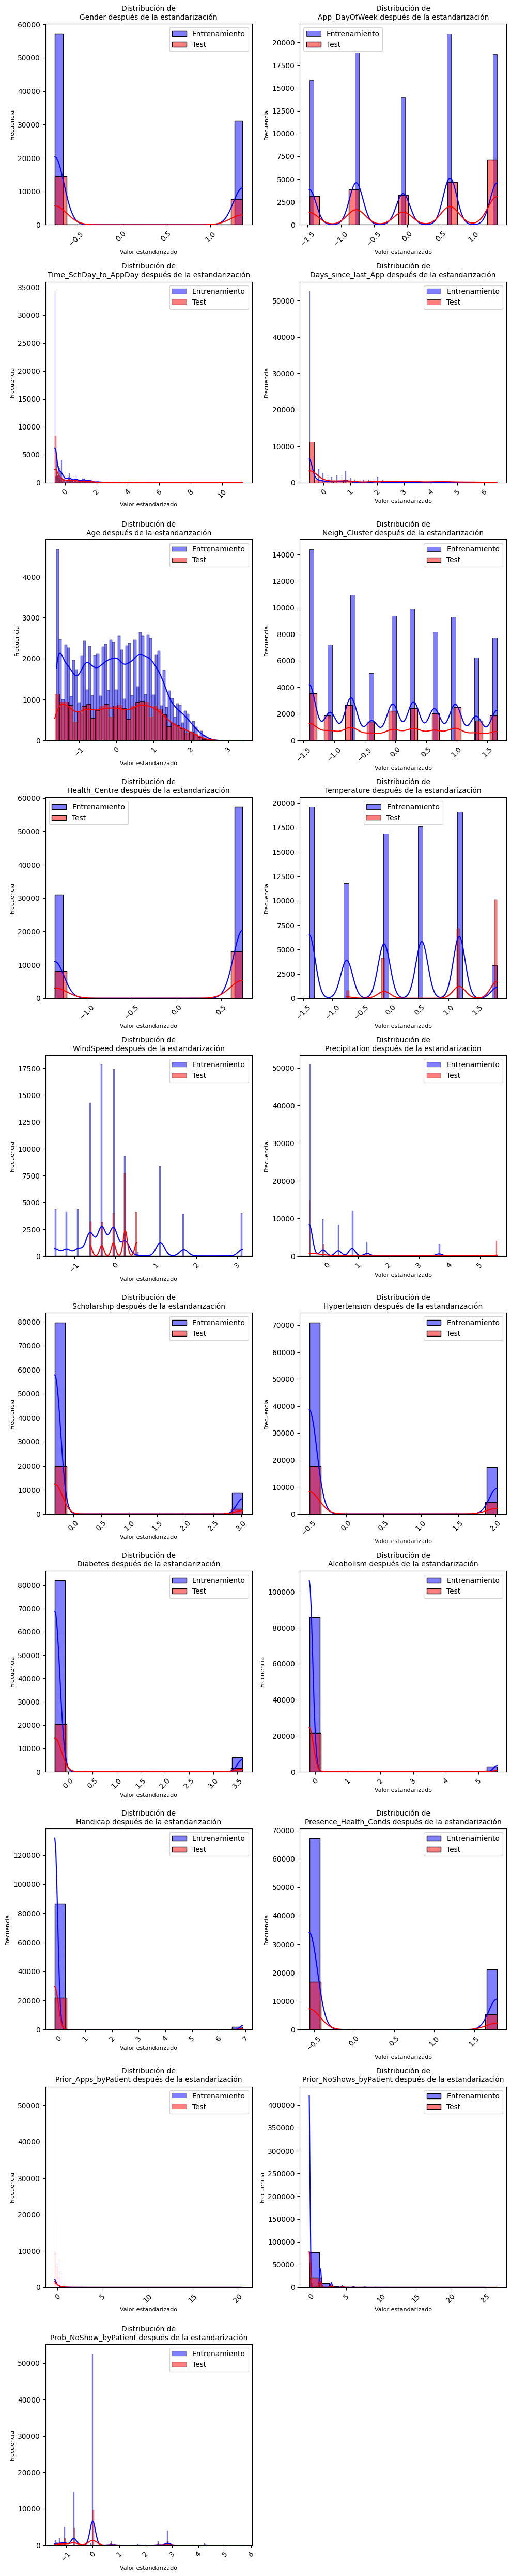

In [126]:
# Convertir los resultados a DataFrame para facilitar la manipulación y visualización, 
# utilizando los nombres de las columnas guardados previamente
X_train_df = pd.DataFrame(X_train_scaled, columns = column_names)
X_test_df = pd.DataFrame(X_test_scaled, columns = column_names)

# Número de características en el DataFrame
num_features = X_train_df.shape[1]

# Número de columnas para los sub-gráficos
num_columns = 2

# Calcular el número de filas basado en el número de características y columnas
num_rows = num_features // num_columns + (num_features % num_columns > 0)


# Crear una figura grande para acomodar todos los sub-gráficos
plt.figure(figsize=(10, 5 * num_rows))

# Crear un histograma para cada característica
for i in range(num_features):
    plt.subplot(num_rows, num_columns, i+1)
    
    # Histograma de los datos de entrenamiento en azul
    sns.histplot(X_train_df.iloc[:, i], kde=True, color='blue', alpha=0.5, label='Entrenamiento')
    
    # Histograma de los datos de test en rojo
    sns.histplot(X_test_df.iloc[:, i], kde=True, color='red', alpha=0.5, label='Test')
    
    # Usar un salto de línea para dividir el título en dos líneas
    plt.title(f'Distribución de\n{column_names[i]} después de la estandarización', fontsize=10)
    
    plt.xlabel('Valor estandarizado', fontsize=8)
    plt.ylabel('Frecuencia', fontsize=8)
    plt.xticks(rotation=45)
    plt.legend()

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

## 4.2 DATA AUGMENTATION para balancear las clases en el dataset de entrenamiento (**SMOTE** y **EDITED NEAREST NEIGHBOURS**)

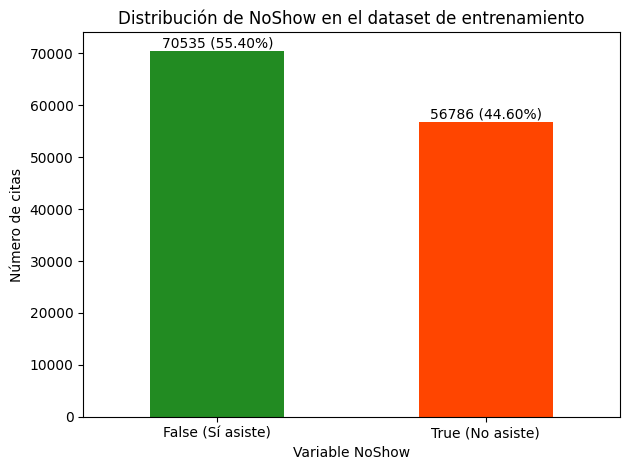

In [123]:
# Se crea una instancia de SMOTE y ENN
smote = SMOTE(sampling_strategy = 'minority',
                random_state = 42)
enn = EditedNearestNeighbours(sampling_strategy = 'not minority',
                                kind_sel = 'all',
                                n_neighbors = 2)

# Se crea una instancia de la clase Pipeline
pipeline = Pipeline([('smote', smote), ('enn', enn)])

# Se aplica el pipeline a los datos
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train_scaled, y_train_set)

# Distribución del dataset posterior a la aplicación de SMOTE-ENN
class_counts = y_train_resampled.value_counts()

# Se define el gráfico con los parámetros adicionales solicitados
class_counts.plot(kind='bar', rot=0, color=['forestgreen', 'orangered'])

# Se añaden etiquetas y título al gráfico
plt.xlabel('Variable NoShow')
plt.ylabel('Número de citas')
plt.title('Distribución de NoShow en el dataset de entrenamiento')

# Se añaden los porcentajes en las barras
for i, count in enumerate(class_counts):
    plt.text(i, count, f'{count} ({count / len(X_train_resampled) * 100:.2f}%)', ha='center', va='bottom')
    
# Se establecen las etiquetas en el eje X
plt.xticks([0, 1], ['False (Sí asiste)', 'True (No asiste)'])

# Se muestra el gráfico
plt.tight_layout()
plt.show()

## 4.3 Reducción de dimensionalidad (**PCA**)

In [124]:
# Aplicar PCA para reducir la dimensionalidad mientras se conserva la mayor cantidad de varianza posible
pca = PCA(n_components = 0.95,
            svd_solver = 'full') 

# Ajustar y transformar los datos de entrenamiento
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test_scaled)

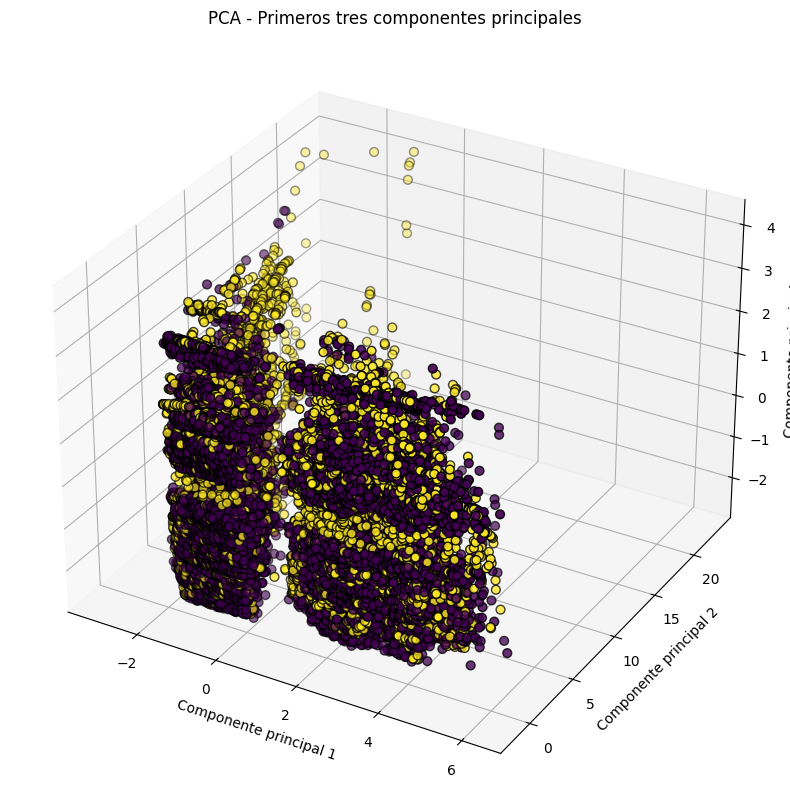

Número de componentes: 16
Varianza explicada por cada componente: [0.13737329 0.121762   0.09203125 0.0689209  0.062564   0.05891554
 0.05696822 0.05155818 0.05094362 0.05045657 0.04339257 0.03914037
 0.03809978 0.03708791 0.03247782 0.02501163]
Varianza total explicada: 0.9667036498924606


In [125]:
# Gráfico de los primeros tres componentes principales en un gráfico 3D
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_pca[:, 0],
            X_train_pca[:, 1],
            X_train_pca[:, 2],
            c = y_train_resampled,
            cmap = 'viridis',
            edgecolor = 'k',
            s = 40)

ax.set_title('PCA - Primeros tres componentes principales')
ax.set_xlabel('Componente principal 1')
ax.set_ylabel('Componente principal 2')
ax.set_zlabel('Componente principal 3')
plt.show()

# Imprimir la cantidad de componentes y la varianza explicada
print(f"Número de componentes: {pca.n_components_}")
print(f"Varianza explicada por cada componente: {pca.explained_variance_ratio_}")
print(f"Varianza total explicada: {np.sum(pca.explained_variance_ratio_)}")

## 4.4 Se guarda la información de los Datasets de Entrenamiento y Pruebas (**sin aplicar PCA**)

In [128]:
# Exportar los datos de entrenamiento y test en archivos pkl
with open('X_train.pkl', 'wb') as file:
    pickle.dump(X_train_resampled, file)
# Guardar y_train
with open('y_train.pkl', 'wb') as file:
    pickle.dump(y_train_resampled, file)
# Guardar X_test
with open('X_test.pkl', 'wb') as file:
    pickle.dump(X_test_scaled, file)
# Guardar y_test
with open('y_test.pkl', 'wb') as file:
    pickle.dump(y_test_set, file)